In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima
import arch

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima
import arch


year = 2019
ticker = 'IFM'
string = str(year)+'/'+ticker+'.csv'
col_names=['TIME', 'X', 'Y', 'Z'] 

df = pd.read_csv(os.path.join('E:\CTA quant/ml_cta-master/data/index/',string), index_col=0, encoding='gbk')
df.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']

df.rename_axis("type", axis='index', inplace=True)
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)

#df = df.iloc[0:100, :]
#df.head(1000)
df['day'] = df['time'].map(lambda x: x.year)*10000 + df['time'].map(lambda x: x.month)*100 + df['time'].map(lambda x: x.day)




def Get_indices(x):
    
    # return during the hold period

    ret2 = sum(x.return_min)
    vol = x.return_min.std(ddof = 0)
    #vol = np.std(x.return_min.std)
    
    return pd.Series([vol,ret2], index=['Volatility','Logreturn2'])

def get_best_model(df):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5) # [0,1,2,3,4]
    
    for i in pq_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARMA(df, order=(i,j)).fit(
                    method='mle', trend='nc'
                )
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
            except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

def plot_corrs(n):
    n = n # the time interval to partition the price series into
    def func(i):
        return (i - i%n)

    df['ind'] = df.index
    df['ind'] = df.ind.apply(func)
    df['return_min'] = (df['close'])/(df['open'])
    df['return_min'] = np.log(df['return_min'])
    #df['return'] = (df['close']-df['open'].shift(periods = n-1))/(df['open'].shift(periods = m-1))
    df1 = df.copy()
    df1 = df.groupby(df.ind)
    thres_up = 0.00
    thres_down= 0.00
    df1 = df1.apply(Get_indices)
#     fig, axes = plt.subplots(2,2, figsize = (10,10))
#     plot_acf(df1.Logreturn2, ax = axes[0,0])
#     plot_acf(df1.Volatility, ax = axes[0,1])
#     plot_pacf(df1.Logreturn2, ax = axes[1,0])
#     plot_pacf(df1.Volatility, ax = axes[1,1])
    
    return df1

def fit_arma(df):
    # find best order
    # automatically fit the optimal ARIMA model for given time series
    # train_len = int(train_test_split * len(df))
    train_len = len(df)
    arima_model_fitted = pmdarima.auto_arima(df[:train_len], start_p = 2, start_q = 2)
    order = arima_model_fitted.get_params()['order']
    # pmdarima.arima.ARIMA
    # predict = arima_model_fitted.predict(n_periods = len(df)-train_len)
    # res = df[train_len:] - predict
    # plot_acf(res)
    arima_residuals = arima_model_fitted.arima_res_.resid
    # the following plots point to the best garch order
    plot_acf(arima_residuals**2)
    plot_pacf(arima_residuals**2)
    return arima_model_fitted, order

def fit_arma_garch(df, roll_window_len, order):
    # df: log return series, roll_window_len: the time window to conduct ARMA-GARCH fitting on, order: order of GARCH
    n_period = 1
    T = roll_window_len
    preds = []
    for d in range(len(df)-T):
        # fit ARMA on returns 
        best_aic, best_order, best_mdl = get_best_model(df[d:d+T])
        #arima_model_fitted = pmdarima.auto_arima(df[d:d+T])
        #p, d, q = arima_model_fitted.order
        arima_residuals = best_mdl.resid

        # fit a GARCH(order) model on the residuals of the ARMA model
        garch = arch.arch_model(arima_residuals, p=order[0], q=order[1])
        garch_fitted = garch.fit()

        # Use ARMA to predict mu
        predicted_mu = best_mdl.forecast()[0]
        # Use GARCH to predict the residual
        garch_forecast = garch_fitted.forecast(horizon=n_period)
        predicted_et = garch_forecast.mean['h.1'].iloc[-1]
        # # Combine both models' output: yt = mu + et
        prediction = predicted_mu + predicted_et
        preds.append(prediction)
    
    
    return preds

def do_everything(n, roll_window_len):
    df1 = plot_corrs(n = n)
    preds = fit_arma_garch(df1['Logreturn2'], roll_window_len = roll_window_len, order = (1,1))
    T = np.arange(len(preds))
    true_val = df1['Logreturn2'][-len(T):]
    plt.plot(T, preds, label = 'prediction')
    plt.plot(T, true_val, label = 'true value')
    plt.title('prediction of return over period of ' + str(n) + ' mins')
    plt.legend()
    
    pred_bool = [int(preds[i] > 0) for i in range(len(preds))]
    true_bool = [int(list(true_val)[i] > 0) for i in range(len(preds))]
    err = sum(abs(np.asarray(true_bool) - np.asarray(pred_bool)))/len(preds)
    accuracy = 1 - err
    return preds, accuracy
    

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -3069.24 | order: (0, 1)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1558.3015602075134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.301561020298
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.767e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale

aic: -3072.16 | order: (0, 1)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1559.7018732282186
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.701873902527
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3072.09 | order: (0, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 30909265.0080762
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1560.2870523253255
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.287053252908
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3072.02 | order: (0, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 36708355.36849183
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2341482772294.941
Iteration:      3,   Func. Count:     33,   Neg. LLF: 526453827191158.7
Iteration:      4,   Func. Count:     45,   Neg. LLF: 21162674393424.758
Iteration:      5,   Func. Count:     60,   Neg. LLF: 310567267.85431075
Iteration:      6,   Func. Count:     73,   Neg. LLF: 367956854886.2675
Iteration:      7,   Func. Count:     88,   Neg. LLF: 207936528576.2811
Iteration:      8,   Func. Count:    102,   Neg. LLF: -1560.7910869342322
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.7910880694653
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3071.85 | order: (0, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.608329569761204e+17
Iteration:      2,   Func. Count:     18,   Neg. LLF: 212609296038.80557
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.286302378351
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.731e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.358e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -3090.52 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 60141470.675255686
Iteration:      2,   Func. Count:     18,   Neg. LLF: 683065440621.821
Iteration:      3,   Func. Count:     33,   Neg. LLF: 829908097773716.0
Iteration:      4,   Func. Count:     47,   Neg. LLF: -1576.772787648274
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.7727872679488
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3090.54 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 344031960031.44653
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5176535501839.319
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1359902827777.6067
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1078333281287.813
Iteration:      5,   Func. Count:     61,   Neg. LLF: 7423713777733756.0
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1042032779992.6254
Iteration:      7,   Func. Count:     90,   Neg. LLF: -1576.9666140392674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.9666137189447
            Iterations: 11
            Function evaluations: 90
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3090.56 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 30041142.80811947
Iteration:      2,   Func. Count:     18,   Neg. LLF: 21852649299101.17
Iteration:      3,   Func. Count:     33,   Neg. LLF: 21532798.336107995
Iteration:      4,   Func. Count:     45,   Neg. LLF: 6226692793677109.0
Iteration:      5,   Func. Count:     60,   Neg. LLF: 12800896.72722173
Iteration:      6,   Func. Count:     72,   Neg. LLF: 112257790.39691965
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.1414347580287
            Iterations: 9
            Function evaluations: 79
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3090.43 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37924738.13003317
Iteration:      2,   Func. Count:     18,   Neg. LLF: 833380343487062.8
Iteration:      3,   Func. Count:     33,   Neg. LLF: 132607526.90000531
Iteration:      4,   Func. Count:     45,   Neg. LLF: 71759414485680.64
Iteration:      5,   Func. Count:     60,   Neg. LLF: 81338236.67323749
Iteration:      6,   Func. Count:     72,   Neg. LLF: 102927825947533.5
Iteration:      7,   Func. Count:     87,   Neg. LLF: 120579141.80399442
Iteration:      8,   Func. Count:     99,   Neg. LLF: 1034829071144212.8
Iteration:      9,   Func. Count:    114,   Neg. LLF: 159701053.12544703
Iteration:     10,   Func. Count:    125,   Neg. LLF: -1577.1726404210867
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.172640451435
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3090.48 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19338760.288551923
Iteration:      2,   Func. Count:     18,   Neg. LLF: 687036938555332.9
Iteration:      3,   Func. Count:     33,   Neg. LLF: 6.891478650650132e+17
Iteration:      4,   Func. Count:     45,   Neg. LLF: 50754800704559.48
Iteration:      5,   Func. Count:     60,   Neg. LLF: 57539452.24568051
Iteration:      6,   Func. Count:     72,   Neg. LLF: 54460328432646.51
Iteration:      7,   Func. Count:     87,   Neg. LLF: 63230681.27080985
Iteration:      8,   Func. Count:     99,   Neg. LLF: 281937440798282.9
Iteration:      9,   Func. Count:    114,   Neg. LLF: 41840396.72180756
Iteration:     10,   Func. Count:    125,   Neg. LLF: -1577.4975386350839
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.4975389392039
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3090.19 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 25414559.867755327
Iteration:      2,   Func. Count:     18,   Neg. LLF: 293534188543940.4
Iteration:      3,   Func. Count:     30,   Neg. LLF: 127531739220718.72
Iteration:      4,   Func. Count:     42,   Neg. LLF: 299593624229766.94
Iteration:      5,   Func. Count:     54,   Neg. LLF: 124801111344361.19
Iteration:      6,   Func. Count:     65,   Neg. LLF: -1577.5140448906168
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.5140453317983
            Iterations: 10
            Function evaluations: 65
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3094.01 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 34111428.01349542
Iteration:      2,   Func. Count:     18,   Neg. LLF: 462899685956066.0
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3.6889458469073126e+18
Iteration:      4,   Func. Count:     45,   Neg. LLF: 95017737787074.28
Iteration:      5,   Func. Count:     60,   Neg. LLF: 93147505.52470718
Iteration:      6,   Func. Count:     72,   Neg. LLF: 899604477418245.5
Iteration:      7,   Func. Count:     87,   Neg. LLF: 7.130769881577933e+18
Iteration:      8,   Func. Count:     99,   Neg. LLF: 9235839864683.273
Iteration:      9,   Func. Count:    114,   Neg. LLF: 2040930.5763172961
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.937260859693
            Iterations: 13
            Function evaluations: 122
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3096.78 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1112867928.5026166
Iteration:      2,   Func. Count:     18,   Neg. LLF: 219221862504851.28
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3700361177.3002005
Iteration:      4,   Func. Count:     45,   Neg. LLF: 41765388004948.85
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2438547020775778.0
Iteration:      6,   Func. Count:     74,   Neg. LLF: 2324283.914762651
Iteration:      7,   Func. Count:     86,   Neg. LLF: 14026.55326824784
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1582.8827997615972
            Iterations: 10
            Function evaluations: 93
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3097.30 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1649962881.4735637
Iteration:      2,   Func. Count:     18,   Neg. LLF: 127592742769688.25
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1013918879.9906204
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1583.2310899440472
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.2310899349013
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.284e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.275e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -3098.04 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 237464946.77490652
Iteration:      2,   Func. Count:     18,   Neg. LLF: 9924652310374488.0
Iteration:      3,   Func. Count:     30,   Neg. LLF: 63712254279733.13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.8521583132206
            Iterations: 5
            Function evaluations: 37
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3098.05 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 192807961.54234925
Iteration:      2,   Func. Count:     18,   Neg. LLF: 8134443563723982.0
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1584.0334814417963
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.0334816398408
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3098.84 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 166442346.74318498
Iteration:      2,   Func. Count:     18,   Neg. LLF: 117749771352.54666
Iteration:      3,   Func. Count:     33,   Neg. LLF: 356380953439.2123
Iteration:      4,   Func. Count:     43,   Neg. LLF: 5820762.907776399
Iteration:      5,   Func. Count:     55,   Neg. LLF: 958299740849749.2
Iteration:      6,   Func. Count:     70,   Neg. LLF: 1269139447.4041665
Iteration:      7,   Func. Count:     82,   Neg. LLF: 719829425344016.5
Iteration:      8,   Func. Count:     97,   Neg. LLF: 779460504.1952981
Iteration:      9,   Func. Count:    109,   Neg. LLF: 48627554035518.8
Iteration:     10,   Func. Count:    123,   Neg. LLF: -1584.8987128308904
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.8987130568412
            Iterations: 14
            Function evaluations: 123
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3099.21 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 109748469.7487343
Iteration:      2,   Func. Count:     18,   Neg. LLF: 411036332364722.7
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3.33949977868035e+18
Iteration:      4,   Func. Count:     45,   Neg. LLF: 428767752441670.0
Iteration:      5,   Func. Count:     60,   Neg. LLF: 3.15633580331465e+18
Iteration:      6,   Func. Count:     72,   Neg. LLF: 428197602566474.0
Iteration:      7,   Func. Count:     87,   Neg. LLF: 3.168596322408022e+18
Iteration:      8,   Func. Count:     99,   Neg. LLF: 154724759551806.94
Iteration:      9,   Func. Count:    114,   Neg. LLF: 1.2305483411105727e+23
Iteration:     10,   Func. Count:    129,   Neg. LLF: 120019841688254.33
Iteration:     11,   Func. Count:    144,   Neg. LLF: 161688229.81292406
Iteration:     12,   Func. Count:    156,   Neg. LLF: 373967480249764.4
Iteration:     13,   Func. Count:    170,   Neg. LLF: -1585.2148023816
Optimization term

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.263e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.265e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:2

aic: -3099.13 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.146006696644654e+17
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2779514980445260.0
Iteration:      3,   Func. Count:     30,   Neg. LLF: 24535983991814.434
Iteration:      4,   Func. Count:     41,   Neg. LLF: 3676300782652563.5
Iteration:      5,   Func. Count:     56,   Neg. LLF: 1464631705690677.5
Iteration:      6,   Func. Count:     70,   Neg. LLF: -1585.2736112674797
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.2736117612576
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3102.26 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1864824346.7518344
Iteration:      2,   Func. Count:     18,   Neg. LLF: 9121965270779758.0
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1532624417.0819564
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1.4838425171108356e+16
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2210456636.2402782
Iteration:      6,   Func. Count:     72,   Neg. LLF: 3035882784544134.0
Iteration:      7,   Func. Count:     87,   Neg. LLF: 323233922.80441546
Iteration:      8,   Func. Count:     99,   Neg. LLF: 862434912573744.8
Iteration:      9,   Func. Count:    114,   Neg. LLF: 1866011726.5236454
Iteration:     10,   Func. Count:    126,   Neg. LLF: 578741615304116.6
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1588.0499055613886
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.0499057764346
            Iterations: 15
            Function evalua

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3101.60 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2569359777.631128
Iteration:      2,   Func. Count:     18,   Neg. LLF: 9986823469921298.0
Iteration:      3,   Func. Count:     33,   Neg. LLF: 27370009011.849934
Iteration:      4,   Func. Count:     45,   Neg. LLF: 19192074.776946355
Iteration:      5,   Func. Count:     56,   Neg. LLF: -1587.3137088926283
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.3137090547384
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3101.55 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 170811928.9469277
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1587.2743181927597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.2743184878564
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3101.44 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 203799087.62432954
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6478708509616194.0
Iteration:      3,   Func. Count:     33,   Neg. LLF: 8181032602.721849
Iteration:      4,   Func. Count:     45,   Neg. LLF: 8463800993136598.0
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5.10201111658816e+17
Iteration:      6,   Func. Count:     72,   Neg. LLF: 2369705433808767.5
Iteration:      7,   Func. Count:     87,   Neg. LLF: 2982787621.1983547
Iteration:      8,   Func. Count:     99,   Neg. LLF: 1.3317324929009534e+16
Iteration:      9,   Func. Count:    114,   Neg. LLF: 44246411119.843994
Iteration:     10,   Func. Count:    126,   Neg. LLF: 9060821941715624.0
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1587.1243916763326
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.1243920356274
            Iterations: 15
            Function eva

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignor

aic: -3098.26 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3708546501.711436
Iteration:      2,   Func. Count:     18,   Neg. LLF: 134015549918712.92
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1591556113.8402047
Iteration:      4,   Func. Count:     45,   Neg. LLF: 456032377369748.2
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6847330568.146695
Iteration:      6,   Func. Count:     72,   Neg. LLF: 54716417338879.17
Iteration:      7,   Func. Count:     87,   Neg. LLF: 536495054.15366954
Iteration:      8,   Func. Count:     99,   Neg. LLF: 144025366961367.03
Iteration:      9,   Func. Count:    114,   Neg. LLF: 1135383433.1358376
Iteration:     10,   Func. Count:    126,   Neg. LLF: 262192594181225.34
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1583.6468247788107
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.646824503637
            Iterations: 15
            Function evaluations: 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -3099.03 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4911167710.428632
Iteration:      2,   Func. Count:     18,   Neg. LLF: 88037074438840.19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 581815972.3130338
Iteration:      4,   Func. Count:     45,   Neg. LLF: 430671728030632.44
Iteration:      5,   Func. Count:     60,   Neg. LLF: 12366762273.939995
Iteration:      6,   Func. Count:     72,   Neg. LLF: 266691295685064.1
Iteration:      7,   Func. Count:     87,   Neg. LLF: 3566135971.071402
Iteration:      8,   Func. Count:     99,   Neg. LLF: 46665287706308.16
Iteration:      9,   Func. Count:    114,   Neg. LLF: 979763161.2597609
Iteration:     10,   Func. Count:    126,   Neg. LLF: 140304907857334.56
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1584.3388461948548
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.3388459643322
            Iterations: 15
            Function evaluations: 14

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3099.72 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13961422645.10687
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3191197469081.862
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1978899.9933590984
Iteration:      4,   Func. Count:     45,   Neg. LLF: 666879514932071.4
Iteration:      5,   Func. Count:     60,   Neg. LLF: 22934157904.888214
Iteration:      6,   Func. Count:     72,   Neg. LLF: 2222944997268362.2
Iteration:      7,   Func. Count:     87,   Neg. LLF: 83922342094.79202
Iteration:      8,   Func. Count:     99,   Neg. LLF: 829381850929991.0
Iteration:      9,   Func. Count:    114,   Neg. LLF: 30828813018.667118
Iteration:     10,   Func. Count:    126,   Neg. LLF: 1243285629008769.0
Iteration:     11,   Func. Count:    141,   Neg. LLF: 3.605061128607293e+24
Iteration:     12,   Func. Count:    156,   Neg. LLF: 18570043881479.465
Iteration:     13,   Func. Count:    170,   Neg. LLF: -1584.9753934766222
Optimization terminate

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3099.75 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4093838441.48125
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1223624980203437.5
Iteration:      3,   Func. Count:     33,   Neg. LLF: 22055314819.88463
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1365269510624037.2
Iteration:      5,   Func. Count:     60,   Neg. LLF: 23408202329.403355
Iteration:      6,   Func. Count:     72,   Neg. LLF: 456347274140940.5
Iteration:      7,   Func. Count:     87,   Neg. LLF: 6646086502.83063
Iteration:      8,   Func. Count:     99,   Neg. LLF: 40974521.746718764
Iteration:      9,   Func. Count:    110,   Neg. LLF: -1584.8105859337134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.810585790065
            Iterations: 13
            Function evaluations: 110
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3100.34 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3774578668.237414
Iteration:      2,   Func. Count:     18,   Neg. LLF: 615719142244748.2
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5030139981.1153965
Iteration:      4,   Func. Count:     45,   Neg. LLF: 542419336414683.0
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6697389207.056311
Iteration:      6,   Func. Count:     72,   Neg. LLF: 35890603174642.484
Iteration:      7,   Func. Count:     87,   Neg. LLF: 597596041.6506968
Iteration:      8,   Func. Count:     99,   Neg. LLF: 1472996459603403.5
Iteration:      9,   Func. Count:    114,   Neg. LLF: 44794006847.42604
Iteration:     10,   Func. Count:    125,   Neg. LLF: -1585.1328366125667
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.1328365318718
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3100.51 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 312166012.44748896
Iteration:      2,   Func. Count:     18,   Neg. LLF: 867298743829266.4
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1011848696.2383275
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2002039920116011.8
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.4733149057008658e+16
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1837345989414516.5
Iteration:      7,   Func. Count:     89,   Neg. LLF: 12145325789088.621
Iteration:      8,   Func. Count:    101,   Neg. LLF: 280415836701180.0
Iteration:      9,   Func. Count:    116,   Neg. LLF: 208341993.61730313
Iteration:     10,   Func. Count:    128,   Neg. LLF: 9220947619057258.0
Iteration:     11,   Func. Count:    143,   Neg. LLF: 8086765901390.451
Iteration:     12,   Func. Count:    154,   Neg. LLF: -1585.4144417691825
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3100.96 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 345696251.03764904
Iteration:      2,   Func. Count:     18,   Neg. LLF: 82694662420306.12
Iteration:      3,   Func. Count:     33,   Neg. LLF: 4641746.7127193995
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1585.8343843077753
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.8343844155922
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3101.06 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 247468577.56387374
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2209320.375684978
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.9801191364315
            Iterations: 3
            Function evaluations: 26
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3101.07 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 206289678.69289342
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1586.11073126934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.1107315193308
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3099.78 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 64242382.60247346
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1584.9050689341339
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.9050689974604
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.261e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale

aic: -3100.13 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 53910170.78266642
Iteration:      2,   Func. Count:     18,   Neg. LLF: 347420993137755.6
Iteration:      3,   Func. Count:     33,   Neg. LLF: 52596617.089392126
Iteration:      4,   Func. Count:     45,   Neg. LLF: 3187561416423541.0
Iteration:      5,   Func. Count:     57,   Neg. LLF: 28409776650100.438
Iteration:      6,   Func. Count:     69,   Neg. LLF: 397135419726447.1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.3495794345226
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -3100.09 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 36164149.80725342
Iteration:      2,   Func. Count:     18,   Neg. LLF: 10728199865869.512
Iteration:      3,   Func. Count:     33,   Neg. LLF: 11171732.003320968
Iteration:      4,   Func. Count:     45,   Neg. LLF: 9557780241204750.0
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.1658077390814716e+19
Iteration:      6,   Func. Count:     72,   Neg. LLF: 11192335692627.059
Iteration:      7,   Func. Count:     86,   Neg. LLF: -1585.5107074947196
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.510707796627
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3101.02 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.473822236561892e+17
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4635975530716456.0
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2.902786874421459e+16
Iteration:      4,   Func. Count:     45,   Neg. LLF: 7416931195.199748
Iteration:      5,   Func. Count:     57,   Neg. LLF: 9.049344037441309e+18
Iteration:      6,   Func. Count:     69,   Neg. LLF: 14060056.92659646
Iteration:      7,   Func. Count:     81,   Neg. LLF: 264034332261858.0
Iteration:      8,   Func. Count:     96,   Neg. LLF: 1.550464430401064e+18
Iteration:      9,   Func. Count:    110,   Neg. LLF: -1586.0835607653707
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.0835610476029
            Iterations: 13
            Function evaluations: 110
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.249e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.25e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disable

aic: -3100.98 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32826537.744115457
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2496419518972452.0
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1586.5328188698122
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.532819372865
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -3100.89 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29321481.95540814
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13841242559660.488
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5866939302242776.0
Iteration:      4,   Func. Count:     48,   Neg. LLF: 10111754521442.104
Iteration:      5,   Func. Count:     61,   Neg. LLF: -1586.90598113432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.905981790767
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.251e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -3101.36 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 18339355.267727777
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2.160640740642858e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3.046108381151024e+16
Iteration:      4,   Func. Count:     48,   Neg. LLF: 9.85311832212698e+16
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.1515038967767135e+20
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1587.4201861556348
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.4201868444816
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.246e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.257e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:2

aic: -3099.93 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 58739523.608569965
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4.920366250220767e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 8929610859.046753
Iteration:      4,   Func. Count:     45,   Neg. LLF: 896232848670871.5
Iteration:      5,   Func. Count:     60,   Neg. LLF: 4537695348645.679
Iteration:      6,   Func. Count:     70,   Neg. LLF: 6884138.5577953365
Iteration:      7,   Func. Count:     82,   Neg. LLF: 1.1103699838567499e+17
Iteration:      8,   Func. Count:     97,   Neg. LLF: 19320275216.976604
Iteration:      9,   Func. Count:    110,   Neg. LLF: 8.550136137046131e+16
Iteration:     10,   Func. Count:    124,   Neg. LLF: -1585.8115452914521
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.8115456659275
            Iterations: 14
            Function evaluations: 124
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -3097.91 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2649306.983809011
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.0438483401667
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.282e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergenc

aic: -3095.33 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13587538.174720455
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2.837663289451567e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3.5600160010528924e+19
Iteration:      4,   Func. Count:     45,   Neg. LLF: 54853622716489.586
Iteration:      5,   Func. Count:     60,   Neg. LLF: 743491460418145.6
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1018225765.6182508
Iteration:      7,   Func. Count:     87,   Neg. LLF: 4.6696775275776104e+16
Iteration:      8,   Func. Count:    102,   Neg. LLF: 8086549579.993207
Iteration:      9,   Func. Count:    114,   Neg. LLF: 1.3782771220274364e+19
Iteration:     10,   Func. Count:    125,   Neg. LLF: -1583.3212425733425
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.321242856739
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -3095.22 | order: (3, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1583.374500988506
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.3745013634739
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.321e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.318e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -3095.57 | order: (3, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1583.8836652081227
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.883665721336
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


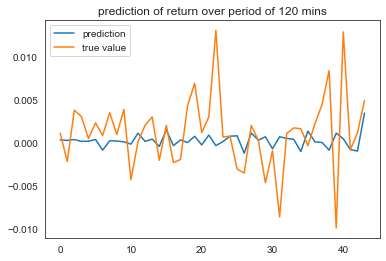

In [10]:
preds, accuracy = do_everything(n = 120, roll_window_len=444)
# T = np.arange(len(preds))
# true_val = df1['Logreturn2'][-len(T):]
# plt.plot(T, preds, label = 'prediction')
# plt.plot(T, true_val, label = 'true value')
# plt.legend()

In [11]:
accuracy

0.7045454545454546

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -7372.27 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 226740972.92749906
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.7274987486959896e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 850016442651.5729
Iteration:      4,   Func. Count:     48,   Neg. LLF: 43128519787.13483
Iteration:      5,   Func. Count:     60,   Neg. LLF: -3744.1380914728747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3744.1380914429337
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7378.50 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 143271382605.5894
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.096881828776489e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.2503137504203514e+17
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.84137282494619e+17
Iteration:      5,   Func. Count:     64,   Neg. LLF: 58356465763629.0
Iteration:      6,   Func. Count:     79,   Neg. LLF: 2.8382937929117534e+23
Iteration:      7,   Func. Count:     94,   Neg. LLF: 1.4481426052317713e+20
Iteration:      8,   Func. Count:    109,   Neg. LLF: 1.4370430118552733e+32
Iteration:      9,   Func. Count:    124,   Neg. LLF: 8.534737263150888e+21
Iteration:     10,   Func. Count:    136,   Neg. LLF: 4.656347429469954e+16
Iteration:     11,   Func. Count:    151,   Neg. LLF: 2.534263880591282e+26
Iteration:     12,   Func. Count:    166,   Neg. LLF: 10863730.507380346
Iteration:     13,   Func. Count:    175,   Neg. LLF: 481388037924.

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7377.60 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 108927278.54174545
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1064173058461370.1
Iteration:      3,   Func. Count:     34,   Neg. LLF: 188888686399316.56
Iteration:      4,   Func. Count:     47,   Neg. LLF: 678378372909270.6
Iteration:      5,   Func. Count:     62,   Neg. LLF: 120530625918079.25
Iteration:      6,   Func. Count:     75,   Neg. LLF: 538965789330671.1
Iteration:      7,   Func. Count:     90,   Neg. LLF: 95915757799947.75
Iteration:      8,   Func. Count:    103,   Neg. LLF: 484580624141771.44
Iteration:      9,   Func. Count:    118,   Neg. LLF: 86285736616489.81
Iteration:     10,   Func. Count:    130,   Neg. LLF: -3745.9699593822297
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3745.9699587926075
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7378.58 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3762722525.284237
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3747.143562904942
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3747.143562419704
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7379.69 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 114156776.0032108
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4541426105332779.0
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.057132190000417e+21
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6.656346097672333e+21
Iteration:      5,   Func. Count:     64,   Neg. LLF: 223614388169.35666
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2.986534764874351e+23
Iteration:      7,   Func. Count:     90,   Neg. LLF: 9.675913145903982e+19
Iteration:      8,   Func. Count:    105,   Neg. LLF: 4.49753376600236e+30
Iteration:      9,   Func. Count:    119,   Neg. LLF: 3.2248574758829304e+21
Iteration:     10,   Func. Count:    129,   Neg. LLF: 9.691826127427526e+16
Iteration:     11,   Func. Count:    143,   Neg. LLF: 3.1560137631338195e+17
Iteration:     12,   Func. Count:    158,   Neg. LLF: 6.816493753124136e+19
Iteration:     13,   Func. Count:    172,   Neg. LLF: 1538.76687213

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7383.45 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2812621011.549156
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3749.149538761169
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3749.149538512312
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -7382.10 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 257707238.50554425
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3749.810838905626
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3749.8108388755627
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.427e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -7382.04 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 285928136.72133666
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3750.4784223960055
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3750.4784226326474
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.427e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -7382.08 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 330966835.41276443
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.187954314006783e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.4010822970828107e+21
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.644388799406826e+19
Iteration:      5,   Func. Count:     64,   Neg. LLF: 2.7620166209339654e+20
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6.651712634602899e+24
Iteration:      7,   Func. Count:     90,   Neg. LLF: 2.7383821514140312e+22
Iteration:      8,   Func. Count:    103,   Neg. LLF: 1.7661055155812846e+19
Iteration:      9,   Func. Count:    118,   Neg. LLF: 2.8712409132870874e+21
Iteration:     10,   Func. Count:    128,   Neg. LLF: 656958312219.5388
Iteration:     11,   Func. Count:    140,   Neg. LLF: 8.071029865158396e+25
Iteration:     12,   Func. Count:    154,   Neg. LLF: -1802.3129869991108
Optimization terminated successfully    (Exit mode 0)
        

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.427e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -7386.21 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 656322379.1558768
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6525273373832879.0
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.411077137204532e+21
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.134035659922585e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 931184054422.5399
Iteration:      6,   Func. Count:     76,   Neg. LLF: 2.3820435502833306e+18
Iteration:      7,   Func. Count:     91,   Neg. LLF: 1.206040356150059e+23
Iteration:      8,   Func. Count:    106,   Neg. LLF: 5.492341451272624e+19
Iteration:      9,   Func. Count:    121,   Neg. LLF: 4.3684828288872874e+21
Iteration:     10,   Func. Count:    130,   Neg. LLF: -1600.7658850601567
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1600.765844289465
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7398.59 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1095673209590.5062
Iteration:      2,   Func. Count:     19,   Neg. LLF: 220779.49290579263
Iteration:      3,   Func. Count:     29,   Neg. LLF: 416451515989.91565
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1520025.776978858
Iteration:      5,   Func. Count:     53,   Neg. LLF: 58641248371.08336
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3758.446295560141
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7397.90 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 50207304215.21359
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3757.822323778433
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7400.19 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 48474119.993632324
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.081432580509357e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 102618244294.54913
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.036126253177756e+17
Iteration:      5,   Func. Count:     62,   Neg. LLF: 17512492230280.303
Iteration:      6,   Func. Count:     76,   Neg. LLF: 3041846963.533284
Iteration:      7,   Func. Count:     89,   Neg. LLF: 4444366835736.866
Iteration:      8,   Func. Count:    104,   Neg. LLF: 111596651.62322237
Iteration:      9,   Func. Count:    116,   Neg. LLF: -3759.5114956639545
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3759.511493978693
            Iterations: 13
            Function evaluations: 116
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignor

aic: -7402.19 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 193162257.02647045
Iteration:      2,   Func. Count:     19,   Neg. LLF: 660019024218740.5
Iteration:      3,   Func. Count:     34,   Neg. LLF: 16727274469.35722
Iteration:      4,   Func. Count:     46,   Neg. LLF: -3759.7856838993675
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3759.7856824112173
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.381e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -7401.43 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 842385510367.0684
Iteration:      2,   Func. Count:     19,   Neg. LLF: 178775.50552342535
Iteration:      3,   Func. Count:     29,   Neg. LLF: 445514525836.3997
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1370404.8635067795
Iteration:      5,   Func. Count:     53,   Neg. LLF: 1.5100950376622018e+16
Iteration:      6,   Func. Count:     68,   Neg. LLF: 3.0097773650931492e+16
Iteration:      7,   Func. Count:     83,   Neg. LLF: 1.5726628713893315e+17
Iteration:      8,   Func. Count:     98,   Neg. LLF: 3360692122095166.0
Iteration:      9,   Func. Count:    113,   Neg. LLF: 1.2473097357834932e+16
Iteration:     10,   Func. Count:    128,   Neg. LLF: 1.0910908313426827e+17
Iteration:     11,   Func. Count:    143,   Neg. LLF: 157363443764.4119
Iteration:     12,   Func. Count:    155,   Neg. LLF: -3759.305544240622
Optimization terminated successfully    (Exit mode 0)
            Current fun

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -7393.20 | order: (1, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 320446948809.26117
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1388706.8552733054
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3753.3026282632773
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7399.83 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5956407.4625787055
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3758.6513582494863
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.385e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -7396.84 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1477534843.8532288
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.244633901656499e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8223460768555194.0
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6.095322049720993e+17
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.6835303693793563e+23
Iteration:      6,   Func. Count:     78,   Neg. LLF: 2.1632911062519012e+21
Iteration:      7,   Func. Count:     92,   Neg. LLF: 5279.793123809312
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5279.793232981699
            Iterations: 9
            Function evaluations: 92
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -7397.81 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 252211134.5092604
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.281352726921958e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1123254927089.3613
Iteration:      4,   Func. Count:     48,   Neg. LLF: 9.006163767125651e+17
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2312090839583510.0
Iteration:      6,   Func. Count:     78,   Neg. LLF: 7.196681875937603e+18
Iteration:      7,   Func. Count:     93,   Neg. LLF: 2.886275853028846e+23
Iteration:      8,   Func. Count:    108,   Neg. LLF: 4.9870026853310054e+19
Iteration:      9,   Func. Count:    123,   Neg. LLF: 7.384537304901531e+30
Iteration:     10,   Func. Count:    138,   Neg. LLF: 573649247270.9459
Iteration:     11,   Func. Count:    152,   Neg. LLF: 1.8200939845155092e+18
Iteration:     12,   Func. Count:    166,   Neg. LLF: -3728.7473711872917
Optimization terminated successfully    (Exit mode 0)
            Curren

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divid

aic: -7397.50 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 282918871.667832
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.987661284360727e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 494108126525.77484
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.9470817382605343e+18
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7302578554187.59
Iteration:      6,   Func. Count:     78,   Neg. LLF: 8.698221807358383e+28
Iteration:      7,   Func. Count:     93,   Neg. LLF: 4.3980957319123677e+21
Iteration:      8,   Func. Count:    103,   Neg. LLF: 9.487703348147175e+21
Iteration:      9,   Func. Count:    115,   Neg. LLF: 22447189630387.46
Iteration:     10,   Func. Count:    129,   Neg. LLF: -3757.6854152765472
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3757.6854142656784
            Iterations: 14
            Function evaluations: 129
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7390.99 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 173825771.9026107
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4494837727652794e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 371006149374.2464
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.502961637332509e+18
Iteration:      5,   Func. Count:     63,   Neg. LLF: 3.4350548238975165e+18
Iteration:      6,   Func. Count:     78,   Neg. LLF: 7.675290158855908e+21
Iteration:      7,   Func. Count:     89,   Neg. LLF: 4.153110279860923e+18
Iteration:      8,   Func. Count:    103,   Neg. LLF: 264232992846.08505
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6.322563295044475e+18
Iteration:     10,   Func. Count:    132,   Neg. LLF: 1.9349731701738238e+23
Iteration:     11,   Func. Count:    147,   Neg. LLF: 1.2188142056012929e+22
Iteration:     12,   Func. Count:    161,   Neg. LLF: 8564.204756672569
Inequality constraints incompatible    (Exit mode 4)
            Curr

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -7398.10 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 250078783151.89975
Iteration:      2,   Func. Count:     19,   Neg. LLF: 404339.36961398576
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3758.1676090012397
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -7397.92 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 194224525.0894015
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.6366167057908068e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 398071092054681.25
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.0252554120673843e+17
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3.355862958068405e+26
Iteration:      6,   Func. Count:     77,   Neg. LLF: 2.6795814012219917e+23
Iteration:      7,   Func. Count:     92,   Neg. LLF: 4.0737771451307105e+25
Iteration:      8,   Func. Count:    106,   Neg. LLF: 8794.800115058057
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8794.800273340701
            Iterations: 10
            Function evaluations: 106
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -7397.94 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 187011048.90242064
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1603223301257192.2
Iteration:      3,   Func. Count:     34,   Neg. LLF: 435215097176729.94
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.433046519894832e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1026113332759123.5
Iteration:      6,   Func. Count:     76,   Neg. LLF: 6.543221961571869e+16
Iteration:      7,   Func. Count:     91,   Neg. LLF: 23511506123048.082
Iteration:      8,   Func. Count:    105,   Neg. LLF: 2103716013154461.0
Iteration:      9,   Func. Count:    120,   Neg. LLF: 2.529233322728738e+17
Iteration:     10,   Func. Count:    135,   Neg. LLF: 52260298601841.81
Iteration:     11,   Func. Count:    150,   Neg. LLF: 4203221441996982.0
Iteration:     12,   Func. Count:    165,   Neg. LLF: 44357034762.12265
Iteration:     13,   Func. Count:    177,   Neg. LLF: -3758.3618956883556
Optimization 

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.374e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for rei

aic: -7402.02 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2270661913.1755996
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.065004989928417e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1986822873147.8325
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.571504626154574e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 359073867395493.4
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1.471393765724926e+16
Iteration:      7,   Func. Count:     91,   Neg. LLF: 264370327542378.8
Iteration:      8,   Func. Count:    104,   Neg. LLF: 3969552036387.893
Iteration:      9,   Func. Count:    118,   Neg. LLF: 9907905922.904377
Iteration:     10,   Func. Count:    131,   Neg. LLF: 2468976631692553.0
Iteration:     11,   Func. Count:    146,   Neg. LLF: 6634196779793518.0
Iteration:     12,   Func. Count:    161,   Neg. LLF: 1.856472985817623e+16
Iteration:     13,   Func. Count:    175,   Neg. LLF: 655164013832804.2
Iteration:    

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -7401.99 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 156669954624.41064
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3761.719842358521
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3761.719840382446
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.374e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


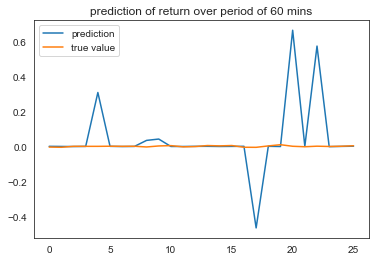

In [6]:
preds, accuracy = do_everything(n = 60, roll_window_len=950)

In [7]:
accuracy

0.5769230769230769

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -13300.59 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 200475787926099.53
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9.306947446257667e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 9.037156360617986e+29
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.119105384191236e+22
Iteration:      5,   Func. Count:     59,   Neg. LLF: 3.850027348709008e+22
Iteration:      6,   Func. Count:     70,   Neg. LLF: 1.5049671242875799e+23
Iteration:      7,   Func. Count:     83,   Neg. LLF: 1428976762090101.8
Iteration:      8,   Func. Count:     98,   Neg. LLF: 1.4320844046437575e+31
Iteration:      9,   Func. Count:    112,   Neg. LLF: 10857.05150075252
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 10857.051707821825
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13307.04 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 272376963668208.38
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2573062952.131495
Iteration:      3,   Func. Count:     32,   Neg. LLF: 352851914.42796785
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1.396658437269308e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5324296904451889.0
Iteration:      6,   Func. Count:     74,   Neg. LLF: 3808163872.837265
Iteration:      7,   Func. Count:     86,   Neg. LLF: -6730.428728437206
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6730.428724418016
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13310.10 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 345858389416973.44
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3525373291.082452
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8098981748762.002
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1239571521226.559
Iteration:      5,   Func. Count:     58,   Neg. LLF: 12199663.272995071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6738.230308546117
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.418e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13310.14 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 23123827515.86072
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.3476212574072325e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.0905386407030084e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6.456459209749206e+18
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7.952407404278778e+16
Iteration:      6,   Func. Count:     78,   Neg. LLF: 290731432229547.8
Iteration:      7,   Func. Count:     93,   Neg. LLF: 1.9302150665324622e+32
Iteration:      8,   Func. Count:    107,   Neg. LLF: 29634.7550978788
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 29634.755575080704
            Iterations: 9
            Function evaluations: 107
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13310.35 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 25525781626.77227
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.111019160568282e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.0821089751798408e+22
Iteration:      4,   Func. Count:     48,   Neg. LLF: 8383.837315779092
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8383.837490670981
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.411e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.417e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13310.86 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 423094857524033.9
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.0886922673969504e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 58641048704610.45
Iteration:      4,   Func. Count:     48,   Neg. LLF: -5036.453335278349
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5036.453274238493
            Iterations: 5
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13310.89 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 35962294468.473335
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.4738948035567205e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.102283421759403e+22
Iteration:      4,   Func. Count:     44,   Neg. LLF: -5892.399850944045
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5892.399806165222
            Iterations: 6
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13314.10 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 416413607528575.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.8781066864519988e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.843035719273107e+24
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.6737763484738606e+18
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.0401739556110922e+26
Iteration:      6,   Func. Count:     77,   Neg. LLF: 16479.619631988364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 16479.619919472687
            Iterations: 6
            Function evaluations: 77
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13314.68 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24585879841.950127
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.66736506757806e+20
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5290.226087567842
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5290.226027671641
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13317.85 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 15785954269.026793
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.89796211542163e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8.537201171825315e+20
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.719589339940873e+22
Iteration:      5,   Func. Count:     59,   Neg. LLF: -6729.551014931191
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6729.55101083294
            Iterations: 6
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.411e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13317.79 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 267244913603983.2
Iteration:      2,   Func. Count:     19,   Neg. LLF: 43121256385383.375
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6962581893146.514
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1123970248128.706
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1387450944677.0393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 2.6599146423545843e+17
Iteration:      7,   Func. Count:     88,   Neg. LLF: 2.822092488082035e+20
Iteration:      8,   Func. Count:    103,   Neg. LLF: 6.612029882137355e+23
Iteration:      9,   Func. Count:    118,   Neg. LLF: 3496527788881.7144
Iteration:     10,   Func. Count:    129,   Neg. LLF: -5887.051646986993
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5887.051601086785
            Iterations: 14
            Function evaluations: 129
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13317.88 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16708918299.295628
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.91033461099827e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.2172403016812519e+22
Iteration:      4,   Func. Count:     48,   Neg. LLF: 15109.80179739157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 15109.802066659344
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.411e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.405e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13318.04 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 21136315340.79283
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.650468224199375e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.122881589324745e+20
Iteration:      4,   Func. Count:     49,   Neg. LLF: 7.698353114877776e+16
Iteration:      5,   Func. Count:     63,   Neg. LLF: 4.8135583410811085e+19
Iteration:      6,   Func. Count:     78,   Neg. LLF: 4.3355802388331776e+23
Iteration:      7,   Func. Count:     92,   Neg. LLF: 1.1742646729456826e+21
Iteration:      8,   Func. Count:    107,   Neg. LLF: 1.1729050714169868e+29
Iteration:      9,   Func. Count:    121,   Neg. LLF: 9321267143806.838
Iteration:     10,   Func. Count:    134,   Neg. LLF: 2.7994843189669915e+33
Iteration:     11,   Func. Count:    148,   Neg. LLF: 71023.05072281147
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 71023.05180786984
            Iterations: 14
      

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13315.33 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 17548840536.026127
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2786402584.628021
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.140101151589083e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.788236733852223e+22
Iteration:      5,   Func. Count:     61,   Neg. LLF: 28904.42805300604
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 28904.428519498535
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13314.85 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 240121170237088.44
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2311749691852940.0
Iteration:      3,   Func. Count:     34,   Neg. LLF: 31395445349.098335
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8.304901492100293e+20
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.9680426879091956e+16
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.0814988091049755e+18
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6.209414331144477e+30
Iteration:      8,   Func. Count:    106,   Neg. LLF: 6005.393141221511
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6005.393284313397
            Iterations: 10
            Function evaluations: 106
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13315.95 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19495600983.849968
Iteration:      2,   Func. Count:     19,   Neg. LLF: 42232249788116.12
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3.3346348286329626e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6219.216823415675
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6219.216790293247
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13316.13 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 238462611529312.66
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2924484488.760791
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.203803182039537e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.516118401488255e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 9.717528630330819e+19
Iteration:      6,   Func. Count:     76,   Neg. LLF: 3949.3825485430557
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3949.3826660543427
            Iterations: 8
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13327.09 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8064564679.836894
Iteration:      2,   Func. Count:     19,   Neg. LLF: 20678622195338.266
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9.29102009641127e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5741.803044099784
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5741.802993800598
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13320.87 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 156016343692161.12
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0273753155690572e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.673937330708445e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 198672637508075.3
Iteration:      5,   Func. Count:     64,   Neg. LLF: 3.557879109220459e+31
Iteration:      6,   Func. Count:     78,   Neg. LLF: 17055.690858859678
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 17055.6911551608
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13328.21 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5096163232.443062
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0041182548060958e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.2797699524690014e+22
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.457364105526572e+23
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3.4787252234058437e+24
Iteration:      6,   Func. Count:     76,   Neg. LLF: 3991.7483735441097
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3991.7484952887403
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13331.04 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20159746425.99847
Iteration:      2,   Func. Count:     19,   Neg. LLF: 101440566492.0137
Iteration:      3,   Func. Count:     32,   Neg. LLF: 406158403.7943804
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4.324665273465922e+27
Iteration:      5,   Func. Count:     60,   Neg. LLF: 7.18293780659551e+23
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.1819209170545258e+24
Iteration:      7,   Func. Count:     90,   Neg. LLF: 2.0135974140344246e+18
Iteration:      8,   Func. Count:    105,   Neg. LLF: 1.4328047217309009e+23
Iteration:      9,   Func. Count:    117,   Neg. LLF: 1.4301816066442309e+22
Iteration:     10,   Func. Count:    131,   Neg. LLF: 9389.853406488557
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9389.853600446864
            Iterations: 14
            Function evaluations: 131
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13331.08 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16925367705.108427
Iteration:      2,   Func. Count:     19,   Neg. LLF: 387660207740.49554
Iteration:      3,   Func. Count:     32,   Neg. LLF: 66708182961.03319
Iteration:      4,   Func. Count:     44,   Neg. LLF: -6750.858200800047
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6750.858196438689
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13330.84 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14333164279.438847
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.852344305459317e+28
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6363.341965424256
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6363.341936619883
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13331.05 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 35996138436856.67
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.6074366416708444e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.3878664142007852e+21
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3942.114784335199
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3942.114907215543
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13333.10 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13797183602.786905
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4342846091367076e+28
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.1510767745994692e+24
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.115046361369722e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 39897.623449891966
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 39897.624076090266
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13334.39 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3645194839.945638
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.1259269016712066e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 242357361919400.44
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.4636777628891003e+18
Iteration:      5,   Func. Count:     62,   Neg. LLF: 4.294011687297118e+19
Iteration:      6,   Func. Count:     76,   Neg. LLF: -401.86597332619846
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -401.8658950842954
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13335.86 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 144831387269.20996
Iteration:      2,   Func. Count:     19,   Neg. LLF: 26381093988.102486
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6755.460545801036
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13330.49 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1166609188329.398
Iteration:      2,   Func. Count:     19,   Neg. LLF: 200094863638.66394
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7.867176237293323e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5823.933343677385
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5823.933294915133
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13330.50 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1109476423222.8008
Iteration:      2,   Func. Count:     19,   Neg. LLF: 190039525533.08582
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.0730905862083727e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 5.850829947490445e+24
Iteration:      5,   Func. Count:     61,   Neg. LLF: -4809.0664424984025
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4809.066378670333
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13331.72 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2662439262742.9565
Iteration:      2,   Func. Count:     19,   Neg. LLF: 470834447753.512
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.5465696656364383e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6461.935676904895
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6461.935654134494
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.393e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13329.44 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 17978107494397.86
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4745199401905747e+20
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5663.682288750624
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5663.682235638964
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13325.95 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1111160911498.019
Iteration:      2,   Func. Count:     19,   Neg. LLF: 985485914.5613147
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.960111780993944e+21
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6530.879096787896
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6530.879078633345
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13330.09 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1292098865.0437627
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.9852282040513394e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.9578617077087212e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 367176364444.5001
Iteration:      5,   Func. Count:     62,   Neg. LLF: 5.984530656883493e+18
Iteration:      6,   Func. Count:     77,   Neg. LLF: 3.1031321096588696e+20
Iteration:      7,   Func. Count:     91,   Neg. LLF: 1349.207915133151
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1349.2080078487513
            Iterations: 9
            Function evaluations: 91
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13332.04 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 51160323534511.61
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.316089686582084e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6187379688234446.0
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3035001109.6354184
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2.399989493700327e+19
Iteration:      6,   Func. Count:     75,   Neg. LLF: -6303.357999433929
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6303.357968835861
            Iterations: 9
            Function evaluations: 75
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13330.06 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1934386231.3498282
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6557523244390.502
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7.25922772800658e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.9078149486726854e+25
Iteration:      5,   Func. Count:     61,   Neg. LLF: 9431.696903946604
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9431.69709624726
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.401e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13326.74 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1636722757.6605408
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4780209181768.344
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.332283989630314e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5168.874374343142
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5168.874314153912
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13330.21 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2217650508.1553483
Iteration:      2,   Func. Count:     19,   Neg. LLF: 390328152.7741177
Iteration:      3,   Func. Count:     32,   Neg. LLF: 70620398.84311861
Iteration:      4,   Func. Count:     45,   Neg. LLF: 213173495997.99988
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6751.793446067152
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13330.23 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44685681578874.05
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7884932933414.791
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.0167263285017475e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6401.867790716493
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6401.867766173321
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.4e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you ca

aic: -13330.21 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3427741365.8123307
Iteration:      2,   Func. Count:     19,   Neg. LLF: 607353021.401536
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.3671032576619913e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6303.496891969997
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6303.496862526254
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13331.90 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5678735984.285944
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1047782185.7227745
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.2471666666684875e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.5719185092257935e+19
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1265501422358.5845
Iteration:      6,   Func. Count:     72,   Neg. LLF: -6134.057281365196
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6134.057244382951
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.393e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13329.94 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4741659519.862352
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12023545758683.316
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.9237591419550163e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.090815995964756e+25
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6127.829123369847
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6127.829268208202
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13339.15 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4318163986.326861
Iteration:      2,   Func. Count:     19,   Neg. LLF: 17436088315726.93
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.225486678205524e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6065.719888692169
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6065.7198482006515
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13338.36 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5749620243058.043
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1091163475040.2347
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7.795294560243874e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5829.835183547434
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5829.835135013684
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.387e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13335.67 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4431419870644.056
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4521288411430581e+20
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5230.016321611978
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5230.016261308625
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13333.72 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5271563675409.529
Iteration:      2,   Func. Count:     19,   Neg. LLF: 950303069292.3668
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.7303458086031557e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.4570510934912407e+31
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5988.6823658881385
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5988.68251269552
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13335.03 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7375300170668.613
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6654997505.461019
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.429961692840137e+22
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5830.810672173754
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5830.810623844769
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

aic: -13334.18 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 57632752371448.89
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10429319703979.25
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1887461204457.9734
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4.2272972981981135e+19
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5.576392043915813e+21
Iteration:      6,   Func. Count:     74,   Neg. LLF: 9500.939090976553
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9500.939284033848
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.397e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13335.81 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2678354429351.1953
Iteration:      2,   Func. Count:     19,   Neg. LLF: 484692695482.87445
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6.395336473989581e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5922.288412667172
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5922.288366807753
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.4e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceW

aic: -13336.25 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9943695297.103575
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.114642794682438e+28
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.7664412822147315e+31
Iteration:      4,   Func. Count:     48,   Neg. LLF: 13899.65825692956
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 13899.65851251144
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13338.30 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4269570318693.9863
Iteration:      2,   Func. Count:     19,   Neg. LLF: 792249646829.4059
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4.304111989950367e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 70165636821830.83
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.763937677892809e+33
Iteration:      6,   Func. Count:     76,   Neg. LLF: 60174.16119881876
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 60174.162120237255
            Iterations: 8
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13340.28 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 50195675340.53149
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1488280998979.3171
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1877209060.2225454
Iteration:      4,   Func. Count:     45,   Neg. LLF: 55183693997.41966
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6760.911790830831
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13339.92 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9243677358938.27
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1774430053239.8005
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9.191556723118973e+17
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6573.328283726969
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6573.328268211153
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13340.14 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7672765163330.546
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1482125975855.7822
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4.3252795239942234e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 9.427824635754075e+30
Iteration:      5,   Func. Count:     61,   Neg. LLF: 3549.4791246903283
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3549.479242511014
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13338.15 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9105761766268.59
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1736350283284.5615
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.077452569730658e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.2077292156824e+31
Iteration:      5,   Func. Count:     61,   Neg. LLF: 15405.311057194976
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 15405.311333008785
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.388e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13337.65 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 48454673614.433655
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.018818521200533e+28
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6309.489127269577
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6309.489095404273
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.394e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.393e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_

aic: -13338.42 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5261053238316.479
Iteration:      2,   Func. Count:     19,   Neg. LLF: 975496311794.2079
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8.927854134399725e+17
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6577.927115051151
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6577.927100025055
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13340.06 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3069410095163.119
Iteration:      2,   Func. Count:     19,   Neg. LLF: 569787280379.9523
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9808507132139566.0
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3607933364897082.5
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5.995785437509325e+18
Iteration:      6,   Func. Count:     75,   Neg. LLF: -5968.832205084587
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5968.83216108221
            Iterations: 9
            Function evaluations: 75
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13339.42 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7023612099676.096
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1306851520952.309
Iteration:      3,   Func. Count:     32,   Neg. LLF: 243192337800.83868
Iteration:      4,   Func. Count:     45,   Neg. LLF: 350853806.2885062
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6758.325910133042
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13342.09 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 345143438342.95215
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1133457056848.6108
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6760.341129009468
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6760.341125086188
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13342.53 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2809877240231.618
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.684175385644764e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6317.758941578198
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6317.75890932009
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import rein

aic: -13343.73 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10811089166.948723
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2039125248.5807917
Iteration:      3,   Func. Count:     32,   Neg. LLF: 384699124.2934005
Iteration:      4,   Func. Count:     45,   Neg. LLF: 72555477.88348466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6759.927272591831
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13343.45 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 35916141634.83192
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8649643223.87808
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.1078384717241993e+28
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.229411866728314e+29
Iteration:      5,   Func. Count:     61,   Neg. LLF: -82.03648111814971
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -82.0363995553626
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13343.46 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 110628475095267.33
Iteration:      2,   Func. Count:     19,   Neg. LLF: 21033274064478.523
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.925803066476682e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.72195975480926e+22
Iteration:      5,   Func. Count:     61,   Neg. LLF: 13914.02664686152
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 13914.026902943127
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13340.63 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7152032554280.593
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1327035596445.4177
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.963588978600825e+16
Iteration:      4,   Func. Count:     47,   Neg. LLF: 810354855196628.9
Iteration:      5,   Func. Count:     60,   Neg. LLF: 9.846150014904778e+17
Iteration:      6,   Func. Count:     75,   Neg. LLF: 8.64669192105446e+30
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1.3792748655907321e+26
Iteration:      8,   Func. Count:    104,   Neg. LLF: 22833746.65142128
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 22833746.987624183
            Iterations: 11
            Function evaluations: 104
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.392e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13340.63 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9824456895795.615
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.625309790127045e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 153762460117104.1
Iteration:      4,   Func. Count:     48,   Neg. LLF: -4292.355692657751
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4292.355626819693
            Iterations: 5
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.392e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13344.50 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 70989555454.47334
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.222579820595284e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4057316634330.7427
Iteration:      4,   Func. Count:     47,   Neg. LLF: 5190441348.607522
Iteration:      5,   Func. Count:     60,   Neg. LLF: 995520000.3866166
Iteration:      6,   Func. Count:     73,   Neg. LLF: 190947010.04985097
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6762.456611428462
            Iterations: 10
            Function evaluations: 81
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.388e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13344.50 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 12339563217599.281
Iteration:      2,   Func. Count:     19,   Neg. LLF: 14769543214.11189
Iteration:      3,   Func. Count:     32,   Neg. LLF: 449935636107.0963
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1.8923817637749706e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 9.404027366826283e+30
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1447.5720635694847
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1447.57216042736
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.388e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_u

aic: -13342.60 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11075377377062.24
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.3342415688827008e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.418273653479918e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.2374456411401413e+19
Iteration:      5,   Func. Count:     64,   Neg. LLF: 3.06801311924766e+27
Iteration:      6,   Func. Count:     79,   Neg. LLF: 8889637916345302.0
Iteration:      7,   Func. Count:     93,   Neg. LLF: 8.443949830774435e+18
Iteration:      8,   Func. Count:    107,   Neg. LLF: -5812.37364756831
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5812.373599638129
            Iterations: 11
            Function evaluations: 107
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13344.75 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7872085299541.921
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1489357580394.6797
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1366022294581136.5
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4139844140266.9272
Iteration:      5,   Func. Count:     60,   Neg. LLF: 517928217086.2386
Iteration:      6,   Func. Count:     73,   Neg. LLF: 16848648153427.396
Iteration:      7,   Func. Count:     85,   Neg. LLF: -6760.882621933641
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6760.882616990778
            Iterations: 11
            Function evaluations: 85
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -13342.71 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14000376204644.428
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.844562464313914e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6587.137280865598
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6587.1372638384355
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13342.81 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16292259312562.633
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.271760769879516e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.818303581780776e+31
Iteration:      4,   Func. Count:     48,   Neg. LLF: 8286.867948167648
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8286.868127923832
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13342.78 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19540154638790.703
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3637437367468.359
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4555295360.033841
Iteration:      4,   Func. Count:     45,   Neg. LLF: 850644031.2846116
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1.3328688507636762e+27
Iteration:      6,   Func. Count:     73,   Neg. LLF: 2.2924900833088904e+30
Iteration:      7,   Func. Count:     87,   Neg. LLF: -1128.7294183557224
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1128.7293440107737
            Iterations: 11
            Function evaluations: 87
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: Convergence

aic: -13342.83 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 343714267099120.94
Iteration:      2,   Func. Count:     19,   Neg. LLF: 64068006298411.47
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8.181873421923798e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 5.058388224919343e+21
Iteration:      5,   Func. Count:     61,   Neg. LLF: 4557.476555458787
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4557.476686297048
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.46 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 253072340692060.62
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2148474469.1388307
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9553356288588.148
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1.3699315837811618e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 7.637096009072902e+24
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1342.1975968307588
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1342.1976906956788
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13343.43 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16303574603.464094
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2977381936.336659
Iteration:      3,   Func. Count:     32,   Neg. LLF: 573639073.1312346
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2533424447299.674
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1.0652875273274686e+17
Iteration:      6,   Func. Count:     73,   Neg. LLF: 7.126390149389285e+17
Iteration:      7,   Func. Count:     88,   Neg. LLF: 241214478366146.25
Iteration:      8,   Func. Count:    102,   Neg. LLF: -6760.641948574326
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6760.64194527048
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.389e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13343.69 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 405764941645408.75
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0751454044909097e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.6248743664397358e+25
Iteration:      4,   Func. Count:     48,   Neg. LLF: 9661.110056604308
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9661.110254028794
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13349.76 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20732024321282.18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4235474804152.197
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.2952522628303232e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6381.0939250458905
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6381.093897981147
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -13349.83 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16595858263671.152
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.854429439129066e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 68918962177170.74
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.1163598607447578e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 5.93099528381435e+23
Iteration:      6,   Func. Count:     76,   Neg. LLF: 6.052512183854268e+25
Iteration:      7,   Func. Count:     90,   Neg. LLF: 3568.952911076687
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3568.953032527751
            Iterations: 9
            Function evaluations: 90
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13349.61 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 35560799152224.86
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.163650914385664e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6074.386537849684
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6074.386495094066
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13351.17 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29534578307980.457
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2894553097091825.5
Iteration:      3,   Func. Count:     34,   Neg. LLF: 901550602368943.1
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.4546509087141896e+19
Iteration:      5,   Func. Count:     61,   Neg. LLF: -5509.685125484875
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5509.685068277865
            Iterations: 7
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.63 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29242107191349.21
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6014950903916.936
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.1670227887687332e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8.456718927538648e+31
Iteration:      5,   Func. Count:     61,   Neg. LLF: 10532.512798476544
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 10532.513009954691
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.377e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13349.47 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 42359639441929.06
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9120871426175.68
Iteration:      3,   Func. Count:     32,   Neg. LLF: 16780227791416.422
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8258581630.096325
Iteration:      5,   Func. Count:     60,   Neg. LLF: 127845009061.75516
Iteration:      6,   Func. Count:     73,   Neg. LLF: 5.793831266490075e+18
Iteration:      7,   Func. Count:     87,   Neg. LLF: -6012.972110038576
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6012.9720655548135
            Iterations: 11
            Function evaluations: 87
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13348.78 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 45320128333802.08
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0156808110310842e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6574.901471434401
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6574.901453705061
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.378e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13349.56 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 404793575387.1731
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.8414746465885435e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 9.197508564724074e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: -600.0335744048839
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -600.0334956449642
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13350.56 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 307668467585.66864
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6695356925350.848
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.1122006768427448e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5655.183350005961
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5655.183297373722
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.377e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.377e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13350.54 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 217478015427.94534
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.3218435630511836e+28
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6526.095139066486
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6526.095118286572
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.38 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31327579541534.883
Iteration:      2,   Func. Count:     19,   Neg. LLF: 33554396029.034588
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1314307466724.3599
Iteration:      4,   Func. Count:     45,   Neg. LLF: 269217601608.98184
Iteration:      5,   Func. Count:     58,   Neg. LLF: 2.315514662255665e+18
Iteration:      6,   Func. Count:     72,   Neg. LLF: -6370.981496626094
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6370.981469167785
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.37 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31633326425185.043
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6483945299472.196
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.2855604329527104e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 20843505603465.895
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6.393182708456806e+27
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.847569880880393e+18
Iteration:      7,   Func. Count:     90,   Neg. LLF: 13854603621869.967
Iteration:      8,   Func. Count:    103,   Neg. LLF: 4.360165055812229e+33
Iteration:      9,   Func. Count:    117,   Neg. LLF: 96474.10676844936
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 96474.10821741563
            Iterations: 12
            Function evaluations: 117
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.14 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 35078866827985.47
Iteration:      2,   Func. Count:     19,   Neg. LLF: 63016400642.712364
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.4888368850557024e+22
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.46476746971143e+23
Iteration:      5,   Func. Count:     61,   Neg. LLF: 37353.258691970164
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 37353.25928195602
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.378e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13348.45 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 47310813794389.17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.234213809775804e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.4110162083638543e+28
Iteration:      4,   Func. Count:     49,   Neg. LLF: 9.37805995230349e+22
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.5653235521244994e+23
Iteration:      6,   Func. Count:     71,   Neg. LLF: -5209.516323035463
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5209.516263474794
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.385e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13348.25 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16385713751448.871
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.5769321657966494e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.1568744517943675e+29
Iteration:      4,   Func. Count:     48,   Neg. LLF: -461.89288379575817
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -461.8928047002147
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.385e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13348.12 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24106765966119.87
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4872691299639.106
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.1893005553227575e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5608.781221124098
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5608.781167295039
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13347.39 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 43446183126721.56
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.1056784448506577e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6554.9865162944025
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6554.986497351527
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -13349.27 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 47124965503682.44
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.9978928981322292e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6842284456097322.0
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.007536928492019e+20
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.4632488977705164e+28
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6.909966896205112e+27
Iteration:      7,   Func. Count:     93,   Neg. LLF: 2.7996743574376763e+23
Iteration:      8,   Func. Count:    106,   Neg. LLF: 251377323864796.3
Iteration:      9,   Func. Count:    119,   Neg. LLF: 51761463590593.06
Iteration:     10,   Func. Count:    131,   Neg. LLF: -6768.1754371962525
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6768.175432961638
            Iterations: 14
            Function evaluations: 131
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13346.90 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 413590475185.57104
Iteration:      2,   Func. Count:     19,   Neg. LLF: 79023370796.39572
Iteration:      3,   Func. Count:     32,   Neg. LLF: 15638920729.456861
Iteration:      4,   Func. Count:     45,   Neg. LLF: 360512169212.53577
Iteration:      5,   Func. Count:     58,   Neg. LLF: 604285471.8828845
Iteration:      6,   Func. Count:     70,   Neg. LLF: -6764.513149162642
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6764.513145503014
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13349.23 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33598445670138.33
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.0814527819687654e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 54136580883090.38
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5.3933091360539134e+32
Iteration:      5,   Func. Count:     63,   Neg. LLF: 36247.56460002451
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 36247.565172894625
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13347.69 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14313370954648.385
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.8771630822813555e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.1834173765727937e+28
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.6708109013716078e+26
Iteration:      5,   Func. Count:     63,   Neg. LLF: -6183.3603732564425
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6183.360334933637
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.59 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 54345334034504.99
Iteration:      2,   Func. Count:     19,   Neg. LLF: 11296010458044.799
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2349445445152.26
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.8542431456709647e+18
Iteration:      5,   Func. Count:     59,   Neg. LLF: -6316.060838961128
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6316.060806499824
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.383e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13353.01 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 23828685401863.93
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5091079193378.153
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.680747602165392e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 983144946938174.1
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3.875072640412582e+19
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.670971842177328e+27
Iteration:      7,   Func. Count:     92,   Neg. LLF: 787261719843407.8
Iteration:      8,   Func. Count:    105,   Neg. LLF: 2.0704923992304668e+18
Iteration:      9,   Func. Count:    119,   Neg. LLF: -6429.127456544698
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6429.127429219552
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13349.70 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 567480405199.7595
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.1252027176144926e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.529199753130109e+22
Iteration:      4,   Func. Count:     48,   Neg. LLF: 9293.00330851639
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9293.003504229664
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13350.11 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16847025575252.97
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5233428567097.714
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1974697973079842.5
Iteration:      4,   Func. Count:     47,   Neg. LLF: 9921458109691.498
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.841536460376693e+20
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.312199325700892e+21
Iteration:      7,   Func. Count:     89,   Neg. LLF: -474.9010848704777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -474.9010041644052
            Iterations: 9
            Function evaluations: 89
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.378e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.378e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13349.92 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29486709178482.547
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6131181459707.512
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6.231553649661247e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.4538282227046356e+24
Iteration:      5,   Func. Count:     61,   Neg. LLF: -5806.391837015435
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5806.39178607054
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13348.32 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 58224789944970.805
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.751912959568693e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.2409695413653263e+24
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.9850983845352629e+21
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2128.807256678433
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2128.807362440277
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.12 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37031745288964.83
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7663356174056.229
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.6395385314619943e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.0561415510179157e+28
Iteration:      5,   Func. Count:     61,   Neg. LLF: -1372.5401613072736
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1372.5400867782637
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13348.30 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 60696596780940.266
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12160770430230.129
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5760486808906581.0
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1950106517997386.2
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5.803790299999662e+17
Iteration:      6,   Func. Count:     76,   Neg. LLF: 2.331703270261074e+24
Iteration:      7,   Func. Count:     90,   Neg. LLF: -5751.442394399666
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5751.442342501754
            Iterations: 11
            Function evaluations: 90
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.385e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13347.74 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 69164408121738.87
Iteration:      2,   Func. Count:     19,   Neg. LLF: 13791726315007.777
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3.682050475596709e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6212.872068294099
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6212.872033039164
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13347.06 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 64371412781946.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12713120971648.793
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7.63962939982332e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5868.3846072330225
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5868.384559623388
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: Convergenc

aic: -13347.84 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 89722361961630.38
Iteration:      2,   Func. Count:     19,   Neg. LLF: 17731949405088.883
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.87233919425188e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6009.151479703847
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6009.151436249906
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13347.63 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 81229875185236.4
Iteration:      2,   Func. Count:     19,   Neg. LLF: 16101501099635.41
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.0528070998305605e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 459057055462237.06
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3.077928166465019e+23
Iteration:      6,   Func. Count:     77,   Neg. LLF: 4.243539566287412e+27
Iteration:      7,   Func. Count:     92,   Neg. LLF: 3.454446340276465e+23
Iteration:      8,   Func. Count:    106,   Neg. LLF: 42374.061781210075
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 42374.06243870266
            Iterations: 10
            Function evaluations: 106
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13349.25 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 49160503739398.41
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9997639010409.164
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9.91005868464061e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8.398649359498332e+31
Iteration:      5,   Func. Count:     61,   Neg. LLF: 11246.737246910001
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 11246.737468243799
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13349.39 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 42288755853881.69
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8606784160273.27
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.7917896641958515e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.7582885830976e+25
Iteration:      5,   Func. Count:     61,   Neg. LLF: -4900.020432449433
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4900.020369080813
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13347.30 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 60832015432096.05
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12342338898084.613
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.6780686394218303e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5402.79999074944
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5402.799933011636
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13346.27 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 55000542290391.42
Iteration:      2,   Func. Count:     19,   Neg. LLF: 106646888536.75182
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.6542638431663278e+22
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5462.967585869876
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5462.967529098718
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.387e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13348.34 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31820070233274.32
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6403354562640.002
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.8123975832875835e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6446.048369060078
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6446.048344686156
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13348.34 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29041706314465.54
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5822445078349.303
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3.9210403638578364e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.8486528512373105e+31
Iteration:      5,   Func. Count:     61,   Neg. LLF: 4364.872916678915
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4364.873046978793
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.379e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13348.34 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 26447350473272.953
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5303666358562.645
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.8268614266593337e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.1343037008091784e+30
Iteration:      5,   Func. Count:     61,   Neg. LLF: 546.0335076709462
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 546.0335952544655
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13346.88 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 39868349206103.36
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7775539354813.457
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.162709365222405e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.210016515641233e+28
Iteration:      5,   Func. Count:     61,   Neg. LLF: -990.2871002662132
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -990.287024438951
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13347.50 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 36514909740689.914
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7163965648293.397
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4.243493377154286e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.2489898920107515e+27
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2.7439796296182143e+23
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.231629340473636e+21
Iteration:      7,   Func. Count:     90,   Neg. LLF: 5.278544490616071e+27
Iteration:      8,   Func. Count:    104,   Neg. LLF: 5.442045040678688e+21
Iteration:      9,   Func. Count:    118,   Neg. LLF: 3694.4151299812806
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3694.415251435225
            Iterations: 11
            Function evaluations: 118
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13347.48 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 36479431865610.65
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.2049626520459202e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4488478575069292.0
Iteration:      4,   Func. Count:     48,   Neg. LLF: 7.484623943854327e+19
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.1906083011723513e+30
Iteration:      6,   Func. Count:     77,   Neg. LLF: -337.3281373701063
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -337.32805790183033
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13345.66 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 205631863791.7642
Iteration:      2,   Func. Count:     19,   Neg. LLF: 48943512380.47362
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7696591660.700134
Iteration:      4,   Func. Count:     45,   Neg. LLF: 80957143788.88116
Iteration:      5,   Func. Count:     58,   Neg. LLF: 353789167.6757489
Iteration:      6,   Func. Count:     70,   Neg. LLF: -6763.395401996837
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6763.395398383079
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.387e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13347.32 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 265109653368.15134
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.328221469002714e+26
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5.155011036667924e+30
Iteration:      4,   Func. Count:     49,   Neg. LLF: 7.013809184706898e+22
Iteration:      5,   Func. Count:     60,   Neg. LLF: 4.254651707231913e+23
Iteration:      6,   Func. Count:     73,   Neg. LLF: 5.187208756318675e+26
Iteration:      7,   Func. Count:     87,   Neg. LLF: 24487.985145739844
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 24487.985550762187
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.38e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13344.81 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 337826721646.7531
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9015165361331.592
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1732044373991.5083
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4.4813457400862765e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.9114112480324024e+24
Iteration:      6,   Func. Count:     74,   Neg. LLF: -5646.170453674572
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5646.17040124794
            Iterations: 9
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.388e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__f

aic: -13343.04 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 41050638887699.17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.4129981003702502e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 7.39983600056811e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.7601592499706452e+16
Iteration:      5,   Func. Count:     63,   Neg. LLF: 29997930332443.84
Iteration:      6,   Func. Count:     76,   Neg. LLF: -6264.814311610728
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6264.814279286698
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13344.23 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 303413148238.38135
Iteration:      2,   Func. Count:     19,   Neg. LLF: 35206501430.06941
Iteration:      3,   Func. Count:     32,   Neg. LLF: 11157363111.59852
Iteration:      4,   Func. Count:     45,   Neg. LLF: 274564389448.50122
Iteration:      5,   Func. Count:     58,   Neg. LLF: 249050156.3193265
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6762.267257114956
            Iterations: 9
            Function evaluations: 66
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.389e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13343.13 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 40271437945182.63
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.3781624488915184e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 52781546264146.76
Iteration:      4,   Func. Count:     48,   Neg. LLF: 177634430361.65408
Iteration:      5,   Func. Count:     61,   Neg. LLF: 7804132104681.023
Iteration:      6,   Func. Count:     74,   Neg. LLF: 6467945168.295469
Iteration:      7,   Func. Count:     86,   Neg. LLF: -6761.4152689014245
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6761.415265262249
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.39e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmod

aic: -13344.79 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 23317007505135.32
Iteration:      2,   Func. Count:     19,   Neg. LLF: 19781071031.42698
Iteration:      3,   Func. Count:     32,   Neg. LLF: 898242419382.6199
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1.7066007564551014e+19
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.0399479035174009e+21
Iteration:      6,   Func. Count:     74,   Neg. LLF: 4476.327711114477
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4476.3278402345795
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13344.81 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24571514753484.664
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4815924038294.688
Iteration:      3,   Func. Count:     32,   Neg. LLF: 944200378926.9836
Iteration:      4,   Func. Count:     45,   Neg. LLF: 185093835574.5005
Iteration:      5,   Func. Count:     58,   Neg. LLF: 3.824743363992929e+18
Iteration:      6,   Func. Count:     72,   Neg. LLF: -6175.325603948887
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6175.325567604559
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13345.23 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 25031664430055.76
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.6015723190827704e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.6010348932588564e+24
Iteration:      4,   Func. Count:     48,   Neg. LLF: -5870.398125754724
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5870.398078725523
            Iterations: 6
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13343.96 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24906931239.626835
Iteration:      2,   Func. Count:     19,   Neg. LLF: 99790870317992.67
Iteration:      3,   Func. Count:     32,   Neg. LLF: 911233869.3782496
Iteration:      4,   Func. Count:     45,   Neg. LLF: 8.236203138402399e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 125067030646848.72
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2.4665367529106544e+16
Iteration:      7,   Func. Count:     89,   Neg. LLF: 1.5973821665511224e+20
Iteration:      8,   Func. Count:    103,   Neg. LLF: -3740.8396552350086
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3740.839587953378
            Iterations: 12
            Function evaluations: 103
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.389e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13345.93 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 72894126167.83441
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.3325254701482625e+27
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.4402463966270826e+31
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2071.0354846451464
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2071.035585904349
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divid

aic: -13342.55 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 30729966548452.17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.664108666411261e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6586.254906605577
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6586.254889177117
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignor

aic: -13343.67 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31199506363340.07
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.931331022996765e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.8532862696364843e+31
Iteration:      4,   Func. Count:     48,   Neg. LLF: 7408.279619244777
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7408.279787967911
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13341.74 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 172764458132.74002
Iteration:      2,   Func. Count:     19,   Neg. LLF: 33061883263.002407
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1151586196433.252
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.980399302420171e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.3563301330481075e+24
Iteration:      6,   Func. Count:     75,   Neg. LLF: 6.315329003476844e+24
Iteration:      7,   Func. Count:     89,   Neg. LLF: 134011.3783145154
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 134011.3803068325
            Iterations: 10
            Function evaluations: 89
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.391e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13341.70 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 34028530734255.17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.9561691780394353e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6172.50399524643
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6172.5039562297725
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.391e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.383e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13345.94 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24524257282468.87
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23190480221.23232
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.5064474135870802e+26
Iteration:      4,   Func. Count:     47,   Neg. LLF: 5.035148874196299e+29
Iteration:      5,   Func. Count:     62,   Neg. LLF: 6.280023784634971e+28
Iteration:      6,   Func. Count:     77,   Neg. LLF: 7.0993561147054905e+22
Iteration:      7,   Func. Count:     88,   Neg. LLF: 4.004574506336754e+21
Iteration:      8,   Func. Count:    102,   Neg. LLF: 4390.434383553216
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4390.434512735853
            Iterations: 10
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13341.89 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 21384547459602.18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4141853692925.019
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7.545557071792901e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8.724631252122312e+31
Iteration:      5,   Func. Count:     61,   Neg. LLF: 16248.227123397535
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 16248.227411901782
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13340.41 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 40401463912855.05
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.2989535710447276e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6511.579182744533
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6511.5791612815465
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.392e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.392e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13341.09 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 43372497496154.016
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.670026240093377e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5780.191971272223
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5780.191919738395
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13341.17 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 200724267573.741
Iteration:      2,   Func. Count:     19,   Neg. LLF: 37977847736.537445
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.1479060913447826e+25
Iteration:      4,   Func. Count:     47,   Neg. LLF: 580079887816.8212
Iteration:      5,   Func. Count:     60,   Neg. LLF: 180044075423.86072
Iteration:      6,   Func. Count:     73,   Neg. LLF: 33303180227.42489
Iteration:      7,   Func. Count:     85,   Neg. LLF: -6760.389053830181
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6760.389050091757
            Iterations: 11
            Function evaluations: 85
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.392e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13342.65 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 120551091101.12288
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23339798140.211193
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.162273910965266e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.298975304065331e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 4.047033086222587e+19
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.0451418930951855e+30
Iteration:      7,   Func. Count:     91,   Neg. LLF: 196.92815005154898
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 196.92823255838823
            Iterations: 9
            Function evaluations: 91
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.385e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13342.52 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29445753391588.58
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5681157622535.648
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1096379184898.5234
Iteration:      4,   Func. Count:     45,   Neg. LLF: 8.487954387765999e+18
Iteration:      5,   Func. Count:     59,   Neg. LLF: -6536.029974842475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6536.02995491685
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -13340.27 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 42865841053702.266
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8329786789014.001
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.623272059733958e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 40225491851384.12
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2.2754218522886172e+33
Iteration:      6,   Func. Count:     75,   Neg. LLF: 47225.37870371332
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 47225.37943749689
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.387e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13341.55 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 606530519291635.6
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.2643089721330024e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.0705902816805416e+16
Iteration:      4,   Func. Count:     48,   Neg. LLF: 7.587006841727643e+20
Iteration:      5,   Func. Count:     63,   Neg. LLF: 3.33919711275265e+29
Iteration:      6,   Func. Count:     77,   Neg. LLF: -5134.1679187603495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5134.167858124754
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.391e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.391e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13341.93 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 625117945057495.6
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.2488657543244563e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.0751982294409836e+25
Iteration:      4,   Func. Count:     48,   Neg. LLF: 5273.295665427301
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5273.295803320355
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13342.24 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 618668434991980.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5985285731.988048
Iteration:      3,   Func. Count:     32,   Neg. LLF: 23737556712368.19
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4650276216816.912
Iteration:      5,   Func. Count:     58,   Neg. LLF: 43657896.23357016
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6764.441498938984
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13346.99 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37271015922421.14
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7369992086415.779
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9.387686563476282e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8.068451960235329e+28
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.6997212695143698e+18
Iteration:      6,   Func. Count:     76,   Neg. LLF: 2.906430204172274e+23
Iteration:      7,   Func. Count:     89,   Neg. LLF: 2.864309419822782e+21
Iteration:      8,   Func. Count:    104,   Neg. LLF: 3791796712489.6934
Iteration:      9,   Func. Count:    116,   Neg. LLF: 8.295208178945232e+22
Iteration:     10,   Func. Count:    131,   Neg. LLF: 4.0054840244807455e+23
Iteration:     11,   Func. Count:    143,   Neg. LLF: -5268.322259079153
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5268.322198760029
            Iterations: 15
         

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.381e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13343.69 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 56193409519724.11
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6.767951822971212e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.599708023947628e+24
Iteration:      4,   Func. Count:     48,   Neg. LLF: -4958.528063747632
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4958.528001487017
            Iterations: 5
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.383e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13345.42 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 518208601590.34204
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.783829413006572e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.2125221804200388e+24
Iteration:      4,   Func. Count:     48,   Neg. LLF: -6417.254720070862
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6417.254695916163
            Iterations: 6
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.388e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13345.62 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 818669791244546.8
Iteration:      2,   Func. Count:     19,   Neg. LLF: 157632658812601.25
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8.01603189173018e+16
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1139169926320.7896
Iteration:      5,   Func. Count:     60,   Neg. LLF: -6763.4300751477695
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6763.430071933346
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.388e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13347.29 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 509274651894129.75
Iteration:      2,   Func. Count:     19,   Neg. LLF: 101139505588865.25
Iteration:      3,   Func. Count:     32,   Neg. LLF: 20092516426398.46
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1640799703653723.5
Iteration:      5,   Func. Count:     60,   Neg. LLF: 21201514078.062534
Iteration:      6,   Func. Count:     73,   Neg. LLF: 2.832143616340557e+22
Iteration:      7,   Func. Count:     87,   Neg. LLF: -6533.932559112594
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6533.932539257397
            Iterations: 11
            Function evaluations: 87
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13346.95 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 852237730762819.2
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7183303188.62174
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1396689927.990216
Iteration:      4,   Func. Count:     45,   Neg. LLF: 271797074.56922746
Iteration:      5,   Func. Count:     58,   Neg. LLF: 5.380604665685103e+20
Iteration:      6,   Func. Count:     73,   Neg. LLF: 2.3923903503805395e+24
Iteration:      7,   Func. Count:     88,   Neg. LLF: 8.572875481817209e+22
Iteration:      8,   Func. Count:     99,   Neg. LLF: 2.788351865134839e+16
Iteration:      9,   Func. Count:    113,   Neg. LLF: 4.602497565737474e+33
Iteration:     10,   Func. Count:    127,   Neg. LLF: 106461.23922871299
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 106461.2408284736
            Iterations: 14
            Function evaluations: 127
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.387e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13347.02 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 38317242417.79898
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.937578492241751e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.418960040122425e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.5423738742206275e+17
Iteration:      5,   Func. Count:     64,   Neg. LLF: 7281973004309.213
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1.2532062710820877e+28
Iteration:      7,   Func. Count:     91,   Neg. LLF: 3.504801963276929e+23
Iteration:      8,   Func. Count:    104,   Neg. LLF: 2.4360469590742497e+22
Iteration:      9,   Func. Count:    118,   Neg. LLF: 15890.91381730534
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 15890.914100040847
            Iterations: 12
            Function evaluations: 118
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13347.05 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 39416290805.60398
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7675662003.142005
Iteration:      3,   Func. Count:     32,   Neg. LLF: 31011603857081.67
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1.946104814919725e+19
Iteration:      5,   Func. Count:     59,   Neg. LLF: -5314.575868751938
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5314.57580898058
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.386e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.387e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_

aic: -13346.30 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 42186386793.321815
Iteration:      2,   Func. Count:     19,   Neg. LLF: 160193760354568.3
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.4650914486373647e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.419870628193448e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.713880859068732e+20
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1899.789849588005
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1899.789946566011
            Iterations: 8
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13350.29 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 40508334289506.43
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7082697656735475.0
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2345900810515450.0
Iteration:      4,   Func. Count:     48,   Neg. LLF: 1.0809885712267712e+30
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.4527684916535095e+24
Iteration:      6,   Func. Count:     78,   Neg. LLF: 1.9190609854432094e+20
Iteration:      7,   Func. Count:     93,   Neg. LLF: 1.2962670981646317e+23
Iteration:      8,   Func. Count:    105,   Neg. LLF: 2.6126786027609983e+24
Iteration:      9,   Func. Count:    119,   Neg. LLF: 119447.04589241049
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 119447.04767633133
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.384e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13351.85 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 388962253910.88165
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8239697951363.103
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.9958157425900495e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.5714480829964642e+20
Iteration:      5,   Func. Count:     62,   Neg. LLF: 6.46118730337084e+25
Iteration:      6,   Func. Count:     76,   Neg. LLF: 4522.835011185229
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4522.835143433447
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.382e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the

aic: -13352.21 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 221337746906.33228
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.070400315837318e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5.798238864153664e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.1840844622805436e+16
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1.3773640218619502e+21
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1.35641679486042e+33
Iteration:      7,   Func. Count:     93,   Neg. LLF: 8451.20653514887
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8451.206718201072
            Iterations: 9
            Function evaluations: 93
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13354.20 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 51343898239590.25
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4314778841673755e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.9142278568927057e+31
Iteration:      4,   Func. Count:     48,   Neg. LLF: 962.1751714284089
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 962.1752638397568
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13354.27 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 39459217048071.75
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4926538443426156e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.295770002509481e+30
Iteration:      4,   Func. Count:     48,   Neg. LLF: 4596.523848725696
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4596.523982730622
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13353.04 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 59542909684153.0
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.2052904286535886e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.2849202951264024e+29
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5985816685340.021
Iteration:      5,   Func. Count:     61,   Neg. LLF: 3.9993343897269885e+33
Iteration:      6,   Func. Count:     75,   Neg. LLF: 79871.05641573519
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 79871.05761522302
            Iterations: 7
            Function evaluations: 75
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.381e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.382e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: Convergenc

aic: -13352.57 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 454783126262.94653
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12185176574390.348
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2482410044411.4746
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.1633468459907383e+19
Iteration:      5,   Func. Count:     59,   Neg. LLF: -5230.870663577166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5230.87060261427
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignor

aic: -13352.37 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 60338794419915.73
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.119757232400389e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6167.713052911911
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6167.713013913777
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13352.93 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 53061793025603.67
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10855006329846.285
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8803026688927420.0
Iteration:      4,   Func. Count:     47,   Neg. LLF: 286842682911084.44
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.005885948742831e+17
Iteration:      6,   Func. Count:     75,   Neg. LLF: 317209246390983.75
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1.3168082095341142e+24
Iteration:      8,   Func. Count:    105,   Neg. LLF: 2.430489854142436e+24
Iteration:      9,   Func. Count:    119,   Neg. LLF: 103233.36742702489
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 103233.36897097222
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13351.54 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 383444639329.681
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.7581594230567364e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.1523745394081523e+22
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3382.4595753207554
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3382.4596928386204
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13352.16 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 73331106951359.34
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0782823310504073e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5669.049008177655
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5669.048954179417
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13354.28 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 299957167095.4937
Iteration:      2,   Func. Count:     19,   Neg. LLF: 61790902111.79052
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8.351485661909697e+26
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.195150348863641e+29
Iteration:      5,   Func. Count:     62,   Neg. LLF: 20818119237639.055
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2.5497237383285104e+31
Iteration:      7,   Func. Count:     89,   Neg. LLF: 2957.1902100771035
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2957.1903225443593
            Iterations: 9
            Function evaluations: 89
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13352.82 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44527954474.91508
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.553370593680196e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 7.806199042238285e+23
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.418692588216374e+27
Iteration:      5,   Func. Count:     62,   Neg. LLF: 66341.33885086534
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 66341.33986058444
            Iterations: 6
            Function evaluations: 62
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.381e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.374e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_

aic: -13356.80 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 939926796891794.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0407844160508142e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6579.550782789502
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6579.550765514454
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13352.90 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 46456414138.87423
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.9037227222116116e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.8838343655843511e+24
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.4920988956250094e+22
Iteration:      5,   Func. Count:     63,   Neg. LLF: 13062.483081700933
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 13062.483325611005
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.381e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13351.43 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 49365321254.51056
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10294416232.180452
Iteration:      3,   Func. Count:     32,   Neg. LLF: 50139218515842.05
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.272391940894771e+21
Iteration:      5,   Func. Count:     60,   Neg. LLF: 3.842374726785122e+21
Iteration:      6,   Func. Count:     74,   Neg. LLF: 56228222787205.2
Iteration:      7,   Func. Count:     88,   Neg. LLF: -6185.388004887363
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6185.387969684785
            Iterations: 10
            Function evaluations: 88
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.376e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.382e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_

aic: -13352.79 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 54858404335.79588
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.826756185364182e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.4724118041437825e+23
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5963.544982567357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5963.544939235818
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13354.09 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1407697455103232.0
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4470215581679667e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5.203802346452953e+23
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8.933397412664741e+23
Iteration:      5,   Func. Count:     60,   Neg. LLF: -6040.822416432251
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6040.8223726696915
            Iterations: 7
            Function evaluations: 60
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.38e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by eith

aic: -13353.41 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1191617769166149.8
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.954296419689252e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.913353117650319e+25
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3828.936582685488
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3828.936705093762
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13353.52 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 61321764558.04635
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.615670237274878e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5197034397721621.0
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.7971876171177715e+20
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.135713959947806e+23
Iteration:      6,   Func. Count:     75,   Neg. LLF: 7.29446286198064e+16
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1.1979711476153395e+21
Iteration:      8,   Func. Count:    104,   Neg. LLF: 3726.5389038271423
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3726.5390245265494
            Iterations: 10
            Function evaluations: 104
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13352.83 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 57729071148.19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.176868854330619e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.361778921903535e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6.596124331142835e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 36166.39847495067
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 36166.399047871666
            Iterations: 5
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13352.98 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 61493690668.111496
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12114917138.731237
Iteration:      3,   Func. Count:     32,   Neg. LLF: 57390148421299.63
Iteration:      4,   Func. Count:     45,   Neg. LLF: 9.220715407719063e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 115074406674064.66
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.3254592304972488e+24
Iteration:      7,   Func. Count:     90,   Neg. LLF: 4.932879792217433e+20
Iteration:      8,   Func. Count:    104,   Neg. LLF: -2375.6634533946353
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2375.6633834918753
            Iterations: 12
            Function evaluations: 104
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13354.30 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 59846948476.08748
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.1322091924049761e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.4434946619618984e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 13212423902510.998
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.567592305590286e+33
Iteration:      6,   Func. Count:     76,   Neg. LLF: 63535.358183091186
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 63535.35915304899
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13359.56 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 39347796728581.8
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.944348586956253e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.2836147332984763e+24
Iteration:      4,   Func. Count:     47,   Neg. LLF: -5223.549735094973
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5223.549675756486
            Iterations: 5
            Function evaluations: 47
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13357.56 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 57680096463770.25
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.4389910906699223e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.6481788479264193e+32
Iteration:      4,   Func. Count:     48,   Neg. LLF: 17635.506068923398
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 17635.50637773918
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13361.76 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31864418064.085934
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.037607875854882e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.0754270899521756e+24
Iteration:      4,   Func. Count:     48,   Neg. LLF: -5832.533334467557
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5832.533286683045
            Iterations: 5
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.37e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.378e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: Convergenc

aic: -13357.49 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44782710635.438156
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.2082104002129061e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.0366498211543135e+20
Iteration:      4,   Func. Count:     49,   Neg. LLF: 9.09763199633537e+22
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.8836533039440217e+23
Iteration:      6,   Func. Count:     72,   Neg. LLF: 1.0502591998241371e+26
Iteration:      7,   Func. Count:     86,   Neg. LLF: 5848.998016273946
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5848.9981647338245
            Iterations: 9
            Function evaluations: 86
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13356.88 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 53286694808.62123
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.171998375246405e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8.672887820285686e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5.804377566841867e+21
Iteration:      5,   Func. Count:     64,   Neg. LLF: 4508963651582.791
Iteration:      6,   Func. Count:     76,   Neg. LLF: 73338242895780.84
Iteration:      7,   Func. Count:     90,   Neg. LLF: -5860.211859394004
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5860.2118128961865
            Iterations: 9
            Function evaluations: 90
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13357.57 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 53640183048.94214
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.999295987348249e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8.445195878494858e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 196081524714735.88
Iteration:      5,   Func. Count:     64,   Neg. LLF: 3.7197808667188983e+24
Iteration:      6,   Func. Count:     79,   Neg. LLF: 4.9455775679430314e+23
Iteration:      7,   Func. Count:     93,   Neg. LLF: 6917.769833793916
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6917.769995790901
            Iterations: 8
            Function evaluations: 93
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13358.37 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1210497848680278.2
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9634867527.675812
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.099348326944043e+23
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5364.331610173083
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5364.331552771035
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13358.67 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 61274616077.242966
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.747350035715708e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6425.461137936305
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6425.461110843264
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13361.14 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 59839806922.57571
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12769384636.840967
Iteration:      3,   Func. Count:     32,   Neg. LLF: 71271114954811.66
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.5849878674926068e+19
Iteration:      5,   Func. Count:     59,   Neg. LLF: -5145.060033323216
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5145.059971203093
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13358.64 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1795134046992557.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.208019026687039e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.565800594992415e+26
Iteration:      4,   Func. Count:     48,   Neg. LLF: -845.4017987240222
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -845.4017223341989
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13361.13 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 97934551070115.92
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.775396147223852e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.1399581258185604e+30
Iteration:      4,   Func. Count:     48,   Neg. LLF: 1021.4255391740805
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1021.425631741728
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.368e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13359.26 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 565028581021.9495
Iteration:      2,   Func. Count:     19,   Neg. LLF: 19705957352725.258
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.0279228480328847e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 142210841.60832483
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1.3556910922369948e+19
Iteration:      6,   Func. Count:     74,   Neg. LLF: 3.381089568960154e+25
Iteration:      7,   Func. Count:     89,   Neg. LLF: 4.888461152533443e+21
Iteration:      8,   Func. Count:    103,   Neg. LLF: -760.4600670585255
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -760.4599900405938
            Iterations: 10
            Function evaluations: 103
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.37e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.364e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13368.14 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 51217743787.126465
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.621534820753106e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6065.075885600836
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6065.075841826465
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13360.07 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 66744942270.70567
Iteration:      2,   Func. Count:     19,   Neg. LLF: 412319429227929.3
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.5741145816871544e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 159866257261789.56
Iteration:      5,   Func. Count:     62,   Neg. LLF: 235615738353.22742
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1379713643870436.5
Iteration:      7,   Func. Count:     88,   Neg. LLF: 1.1465068256498339e+18
Iteration:      8,   Func. Count:    102,   Neg. LLF: -6763.543455681881
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6763.543452720541
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_

aic: -13360.09 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1809351559094793.8
Iteration:      2,   Func. Count:     19,   Neg. LLF: 15161725386.370817
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.2677379501562765e+22
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.0403897999226876e+24
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2.158541196285721e+25
Iteration:      6,   Func. Count:     76,   Neg. LLF: 4839.44744450922
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4839.447579595944
            Iterations: 8
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13368.90 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1666340329672859.0
Iteration:      2,   Func. Count:     19,   Neg. LLF: 14870292357.646408
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.0036734393915193e+21
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.3353499070099842e+16
Iteration:      5,   Func. Count:     61,   Neg. LLF: 1828794775779.2554
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.621532686193693e+22
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1.1316220387775026e+23
Iteration:      8,   Func. Count:    101,   Neg. LLF: -6756.2611267893135
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6756.261121983929
            Iterations: 12
            Function evaluations: 101
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13368.55 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1792646252883690.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.1869433621415203e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5657.0549823068495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5657.054927852758
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13367.87 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1675604836676018.8
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.7537748451595597e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.277505648552249e+27
Iteration:      4,   Func. Count:     48,   Neg. LLF: 59921.12879245622
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 59921.12971040273
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13359.88 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 72600695644.00735
Iteration:      2,   Func. Count:     19,   Neg. LLF: 16629755749.590006
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2.003882891395832e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6343.073794976952
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6343.0737667637095
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13360.41 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 74377518505.70135
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.9383988733211055e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.9597015598381527e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.0733116421203652e+24
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.7803988741341663e+27
Iteration:      6,   Func. Count:     77,   Neg. LLF: 59612.06573587859
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 59612.06664951404
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13370.11 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 68767186061.04037
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.240001817112213e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 9.121359440363366e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6.806062350577818e+22
Iteration:      5,   Func. Count:     60,   Neg. LLF: 15509026557047.826
Iteration:      6,   Func. Count:     73,   Neg. LLF: 3.812634190188723e+32
Iteration:      7,   Func. Count:     87,   Neg. LLF: 19600.116214376067
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 19600.11654967948
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13360.67 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 77062225596.9913
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.223398368300743e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4096071611074.197
Iteration:      4,   Func. Count:     46,   Neg. LLF: 3.974054832469955e+30
Iteration:      5,   Func. Count:     60,   Neg. LLF: 4060.68069962871
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4060.6808227258825
            Iterations: 6
            Function evaluations: 60
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13360.68 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 79870092484.98332
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0139387632254866e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.0791111424592312e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6.05639885588081e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7.66378210397685e+19
Iteration:      6,   Func. Count:     78,   Neg. LLF: 9.08168245779169e+22
Iteration:      7,   Func. Count:     90,   Neg. LLF: 4.715113821669386e+18
Iteration:      8,   Func. Count:    105,   Neg. LLF: 1.9889404798376643e+23
Iteration:      9,   Func. Count:    117,   Neg. LLF: 3.816241963255547e+21
Iteration:     10,   Func. Count:    132,   Neg. LLF: 1.0333963647383084e+26
Iteration:     11,   Func. Count:    146,   Neg. LLF: 8319.91155338721
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8319.91173092519
            Iterations: 14
        

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13360.39 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 78493716891.52031
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.178606442212092e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4934526598681.018
Iteration:      4,   Func. Count:     48,   Neg. LLF: 1.4265302695041982e+23
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1820.015812023592
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1820.0159081140735
            Iterations: 6
            Function evaluations: 62
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.375e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.364e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: Convergenc

aic: -13367.04 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 65966767311.222946
Iteration:      2,   Func. Count:     19,   Neg. LLF: 15646775788.250462
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3.0639636734356803e+21
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.789569956282459e+18
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.0596606665045276e+24
Iteration:      6,   Func. Count:     76,   Neg. LLF: 75585.33191601867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 75585.33306697277
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13361.90 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 63581921712.86519
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.401054980582978e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5984.361631109561
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5984.361585768566
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.367e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13360.59 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 71550070078.53261
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.8645396806934504e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8.94018416973538e+16
Iteration:      4,   Func. Count:     48,   Neg. LLF: 5.412763446223076e+17
Iteration:      5,   Func. Count:     63,   Neg. LLF: 4.646954748194968e+23
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.619186803950805e+23
Iteration:      7,   Func. Count:     91,   Neg. LLF: 20251.015839985
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 20251.01618285442
            Iterations: 8
            Function evaluations: 91
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.368e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.377e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13358.72 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 73274775711.60254
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6.89622502519199e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.5204653462181102e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5821962388649.489
Iteration:      5,   Func. Count:     61,   Neg. LLF: 4.608905643205355e+23
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.990496543733965e+21
Iteration:      7,   Func. Count:     89,   Neg. LLF: 2084.713716034857
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2084.7138144766936
            Iterations: 10
            Function evaluations: 89
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13358.75 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 73240993820.43803
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.8737808520903977e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.1596042073563103e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 8.408809744368309e+22
Iteration:      5,   Func. Count:     61,   Neg. LLF: 4.086937172189721e+25
Iteration:      6,   Func. Count:     76,   Neg. LLF: 9645479069204.99
Iteration:      7,   Func. Count:     89,   Neg. LLF: 2.73938878882303e+30
Iteration:      8,   Func. Count:    103,   Neg. LLF: 5078.75349159397
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5078.753625427207
            Iterations: 10
            Function evaluations: 103
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.377e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -13366.78 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 56274362826.8101
Iteration:      2,   Func. Count:     19,   Neg. LLF: 14020864567.655659
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3495184028.0814424
Iteration:      4,   Func. Count:     45,   Neg. LLF: 871289695.3932898
Iteration:      5,   Func. Count:     58,   Neg. LLF: 7.888687283557829e+21
Iteration:      6,   Func. Count:     73,   Neg. LLF: 1.7439090073677685e+19
Iteration:      7,   Func. Count:     88,   Neg. LLF: 153247681163727.53
Iteration:      8,   Func. Count:    102,   Neg. LLF: -6774.774996536844
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6774.774993958039
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13364.20 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 67873567335.87708
Iteration:      2,   Func. Count:     19,   Neg. LLF: 15936750712.492897
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6.202997759014718e+21
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.5819214189773297e+18
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2.073885904009744e+23
Iteration:      6,   Func. Count:     73,   Neg. LLF: 5.470381184273443e+27
Iteration:      7,   Func. Count:     88,   Neg. LLF: 2.967317064877909e+26
Iteration:      8,   Func. Count:    102,   Neg. LLF: 17227.839133605943
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 17227.83943489884
            Iterations: 10
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13364.78 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 67796449679.12816
Iteration:      2,   Func. Count:     19,   Neg. LLF: 15994851958.792215
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8.658739557028176e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.4875790764365024e+20
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2045476054068.1965
Iteration:      6,   Func. Count:     73,   Neg. LLF: 1.9505570067081774e+24
Iteration:      7,   Func. Count:     87,   Neg. LLF: -6090.375223474761
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6090.375181936943
            Iterations: 10
            Function evaluations: 87
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.371e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13364.58 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 64283179466.025406
Iteration:      2,   Func. Count:     19,   Neg. LLF: 15131013932.09013
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3564608150.735194
Iteration:      4,   Func. Count:     45,   Neg. LLF: 839678028.5526419
Iteration:      5,   Func. Count:     58,   Neg. LLF: 4.609641423602736e+21
Iteration:      6,   Func. Count:     73,   Neg. LLF: 2.554946402598642e+18
Iteration:      7,   Func. Count:     88,   Neg. LLF: 2.544180721414222e+22
Iteration:      8,   Func. Count:    102,   Neg. LLF: 207.35617804647774
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 207.35625992764346
            Iterations: 11
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.372e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.358e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_

aic: -13374.74 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 55109226224.40449
Iteration:      2,   Func. Count:     19,   Neg. LLF: 13754890411.337479
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.0519147555511549e+22
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.0375333932180259e+19
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2.223806647928753e+23
Iteration:      6,   Func. Count:     74,   Neg. LLF: 2.4739091970106725e+22
Iteration:      7,   Func. Count:     88,   Neg. LLF: 3490.734094894986
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3490.7342104141085
            Iterations: 9
            Function evaluations: 88
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13364.97 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 64747802505.19878
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.287485916577504e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6505.4957300044925
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6505.495708570472
            Iterations: 3
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.371e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13364.95 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 62003260657.96574
Iteration:      2,   Func. Count:     19,   Neg. LLF: 14710820677.878492
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9.830610508702563e+21
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.752404804630491e+19
Iteration:      5,   Func. Count:     62,   Neg. LLF: 84179192470811.0
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.610947353644999e+23
Iteration:      7,   Func. Count:     91,   Neg. LLF: 29528.43544844302
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 29528.435925146456
            Iterations: 8
            Function evaluations: 91
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.371e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.357e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: Convergenc

aic: -13375.39 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 55537202820.49242
Iteration:      2,   Func. Count:     19,   Neg. LLF: 13995121469.065529
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.6220305695456205e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.6379828980244454e+20
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1363778989028.817
Iteration:      6,   Func. Count:     72,   Neg. LLF: 4.309148367985774e+22
Iteration:      7,   Func. Count:     83,   Neg. LLF: 1.1544349001232687e+24
Iteration:      8,   Func. Count:     97,   Neg. LLF: 119414.58526039994
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 119414.58706050357
            Iterations: 11
            Function evaluations: 97
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13375.52 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6789.370227712381
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6789.370226327303
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13375.80 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 46903869349.756065
Iteration:      2,   Func. Count:     19,   Neg. LLF: 11835102260.520357
Iteration:      3,   Func. Count:     31,   Neg. LLF: -6789.4955730547135
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6789.495571596083
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13366.39 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 51320622302.053345
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6782.963871577511
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6782.9638702857355
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.37e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.363e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13369.90 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 51093772891.36864
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6787.2641380294335
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6787.26413653312
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13367.36 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6783.246410016427
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6783.246408464271
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.369e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.369e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13367.95 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 61460477305.43036
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6783.899076053536
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6783.899074645278
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13368.09 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 64004997744.3314
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6784.272202809696
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6784.272201536632
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13371.75 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6790.41364690595
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6790.413645724066
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.36e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.367e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13369.38 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 68595072125.836044
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.971128081922035e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.0174605442159741e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2297478109284.2886
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.3834407747669036e+16
Iteration:      6,   Func. Count:     73,   Neg. LLF: -6140.659783330704
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6140.659746325955
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13373.48 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 772792317519160.5
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6790.965565068247
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6790.965564124266
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13370.24 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 72676679166.96918
Iteration:      2,   Func. Count:     19,   Neg. LLF: 241314422507212.88
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.1821871917920825e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -5613.475591321864
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5613.4755384819155
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.367e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13372.41 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 65161993924.515335
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6788.093448663529
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6788.093447870607
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13372.35 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6788.41604153361
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6788.41604083635
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13372.48 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 745978218975528.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.797156891765657e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.7718899526591694e+27
Iteration:      4,   Func. Count:     48,   Neg. LLF: 78911.93855135168
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 78911.93975467392
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13372.44 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 683731867180639.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.564066304350718e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8.998760377103303e+23
Iteration:      4,   Func. Count:     48,   Neg. LLF: 78107.25594437585
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 78107.25713602368
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13373.68 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 583743273931220.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6.723032312377387e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.245360791006692e+29
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5.935966323831615e+20
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1.506268514623422e+28
Iteration:      6,   Func. Count:     79,   Neg. LLF: 2.8894441440999252e+16
Iteration:      7,   Func. Count:     93,   Neg. LLF: 5.4966082731339046e+26
Iteration:      8,   Func. Count:    108,   Neg. LLF: 1.7954047507771408e+28
Iteration:      9,   Func. Count:    123,   Neg. LLF: 3.2315652032715084e+16
Iteration:     10,   Func. Count:    136,   Neg. LLF: -6003.64962577436
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6003.649583549864
            Iterations: 11
            Function evaluations: 136
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13374.30 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6791.270471854584
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6791.270471713
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.363e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.363e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13374.27 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6791.94382450227
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6791.943824561648
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13374.69 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6795.727482785371
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6795.727483400435
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13374.26 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6794.591504088637
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6794.5915042854995
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13374.34 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6795.091489066961
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6795.0914893697245
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.36e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

aic: -13377.45 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6796.58137507259
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6796.581375313594
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.358e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.349e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13386.64 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6801.112627287418
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6801.112626896231
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13385.61 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 649380662167269.0
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6797.446829078475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6797.4468286439
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.354e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13385.51 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6797.824737777062
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6797.824737443536
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13385.55 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6801.283866462814
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6801.283866641812
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.351e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.346e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13389.37 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32940352341.515984
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9245790667.646519
Iteration:      3,   Func. Count:     31,   Neg. LLF: -6804.09566331721
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6804.095663298639
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13385.64 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6799.8473735281395
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6799.847373729033
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13385.56 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6800.567566840655
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6800.567567230661
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.354e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13386.63 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6801.62030348966
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6801.620303998414
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.353e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13401.21 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6814.304565680902
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6814.304567018761
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.337e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13386.79 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.7846362088848276e+21
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6803.541530460766
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6803.541531439025
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.353e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13386.97 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6804.586383541598
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6804.586384705397
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.353e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13387.28 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6805.571066260154
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6805.571067601246
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.352e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.346e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_

aic: -13388.57 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6811.025944930769
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6811.025946459046
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13385.20 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6808.001825845786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6808.001827458853
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.351e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13385.29 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6809.121290721588
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6809.121292561582
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.351e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.339e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13397.57 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6813.797886217887
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6813.797887566178
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13387.73 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6811.556758587578
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6811.556760702273
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.349e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13391.75 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6813.086176680801
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6813.086178729376
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.346e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.34e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__f

aic: -13398.45 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6814.86105696656
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6814.861058750726
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13409.00 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6817.777763244807
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6817.777764246795
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13407.63 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6819.377376565557
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6819.377377995571
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13409.67 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6820.74741153574
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6820.747413069617
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13409.69 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3439871026997512e+21
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6821.9147384494445
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6821.91474024922
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13402.10 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6819.789142590995
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6819.789145003554
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13409.97 | order: (4, 4)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6824.492899158804
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6824.492901456235
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13403.80 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6822.6277104864475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6822.627713358204
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.336e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.334e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13405.42 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6824.119190051076
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6824.1191930934365
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13410.92 | order: (2, 2)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6821.112650130732
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6821.112652540495
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.333e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13417.31 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6828.049793879852
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6828.049796702475
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.324e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13417.78 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6829.412533919185
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6829.412536981841
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13427.38 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.41726474457027e+20
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6831.24585386859
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6831.245856431596
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.316e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13428.80 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6832.447433736899
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6832.447436421758
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.315e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13433.29 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6829.866131118955
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6829.866132625028
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignor

aic: -13431.81 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6216381771.354515
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6828.112317173796
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6828.11231844451
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.312e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13432.29 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6829.162269338079
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6829.162270808413
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.312e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13446.79 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6831.734501924429
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6831.734502650806
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.3e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you ca

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13473.92 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 204726656451054.28
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.3159452915305878e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5555.621695667108
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5555.62163957686
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.275e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13475.92 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16749849302.33884
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.889177653248151e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 76581029881189.3
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.034615596015294e+23
Iteration:      5,   Func. Count:     62,   Neg. LLF: 8.611420195506333e+24
Iteration:      6,   Func. Count:     76,   Neg. LLF: 69190.8831184472
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 69190.88417685585
            Iterations: 6
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.275e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13486.24 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 613694923.4073989
Iteration:      2,   Func. Count:     19,   Neg. LLF: 214490073.83767158
Iteration:      3,   Func. Count:     32,   Neg. LLF: 74969851.05598783
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6838.361816170756
            Iterations: 5
            Function evaluations: 41
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.267e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13486.28 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 344336083.4231709
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6839.004316806579
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6839.004314956148
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.267e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13486.50 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6839.800320581585
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6839.800318924285
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.267e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13486.63 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1270532061.5829334
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.4703395820122507e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.707127670805678e+16
Iteration:      4,   Func. Count:     48,   Neg. LLF: 4.0458548942226764e+23
Iteration:      5,   Func. Count:     62,   Neg. LLF: 7.69244435764092e+23
Iteration:      6,   Func. Count:     76,   Neg. LLF: 138833.50352254813
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 138833.50560530717
            Iterations: 7
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.267e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.267e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13487.21 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4403450803.992832
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1567744785.810522
Iteration:      3,   Func. Count:     31,   Neg. LLF: -6841.484668955198
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6841.484667674057
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13492.13 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 125519191.49182338
Iteration:      2,   Func. Count:     19,   Neg. LLF: -6843.185145059207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6843.185143696141
            Iterations: 2
            Function evaluations: 19
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13492.97 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 196704328.0922547
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6844.021914748484
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6844.021913531267
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.262e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13493.24 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 665413329159.3997
Iteration:      2,   Func. Count:     19,   Neg. LLF: 242181222353.50894
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.193690405962461e+21
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.6024455505252477e+17
Iteration:      5,   Func. Count:     62,   Neg. LLF: 8972729476678.61
Iteration:      6,   Func. Count:     76,   Neg. LLF: 3.4574859386906263e+28
Iteration:      7,   Func. Count:     91,   Neg. LLF: 2.9651348481555057e+27
Iteration:      8,   Func. Count:    103,   Neg. LLF: -6779.982362877348
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6779.9823576025965
            Iterations: 10
            Function evaluations: 103
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.262e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.262e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -13493.31 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29927810855.692013
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6845.866887444228
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13493.12 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 421685979741.74585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 155161803051.17944
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6846.730111700339
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13494.01 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2234907755836.4995
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9.73296754844939e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.4454787685246588e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5.669754784313532e+19
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1.834034312196817e+22
Iteration:      6,   Func. Count:     73,   Neg. LLF: -3424.9007042696344
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3424.9006364247434
            Iterations: 7
            Function evaluations: 73
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13498.51 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10879413706567.71
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6849.342877583145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6849.342877147581
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13514.99 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3328319488.64131
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.338208944610625e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.871646996483205e+27
Iteration:      4,   Func. Count:     48,   Neg. LLF: 120516.26381584
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 120516.2656323609
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.245e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13515.11 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 40249487256574.94
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6853.106102778676
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6853.106101442822
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.245e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13515.01 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32647140730354.566
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.219227973380629e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.4695874812734907e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 591510349773.155
Iteration:      5,   Func. Count:     59,   Neg. LLF: 2.3957096295435866e+22
Iteration:      6,   Func. Count:     69,   Neg. LLF: -6360.862896352869
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6360.8628661836165
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.245e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13516.28 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9071418474122.727
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6855.166928815904
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6855.166927885486
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.244e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13515.62 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8401654490656.187
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.590255495431416e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.8297306252686447e+24
Iteration:      4,   Func. Count:     49,   Neg. LLF: 4.126494883558689e+20
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2975.2448932582647
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2975.2449942590924
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.245e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13515.71 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13998301282055.752
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.5247653848365605e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.28498194659652e+26
Iteration:      4,   Func. Count:     49,   Neg. LLF: 310853257959628.9
Iteration:      5,   Func. Count:     64,   Neg. LLF: 2.594438032572692e+26
Iteration:      6,   Func. Count:     79,   Neg. LLF: 2.9724223469369094e+25
Iteration:      7,   Func. Count:     93,   Neg. LLF: 32332.91724668379
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 32332.917758814598
            Iterations: 8
            Function evaluations: 93
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.245e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13515.86 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 17505917990317.191
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.3388675593790654e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.4063734761926601e+23
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8.655544615825947e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.6236715007482148e+22
Iteration:      6,   Func. Count:     72,   Neg. LLF: 2.8141058062664365e+22
Iteration:      7,   Func. Count:     83,   Neg. LLF: 2.727074260900864e+19
Iteration:      8,   Func. Count:     98,   Neg. LLF: 9.983612244761331e+24
Iteration:      9,   Func. Count:    112,   Neg. LLF: 19789.059565539486
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 19789.05989408091
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.245e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13516.18 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6858.156107328226
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6858.15610711804
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.244e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13522.60 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 58959515897292.97
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0628375646405738e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.241178835963457e+26
Iteration:      4,   Func. Count:     49,   Neg. LLF: 8.191768480638059e+21
Iteration:      5,   Func. Count:     63,   Neg. LLF: 13877.973456088543
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 13877.97370020324
            Iterations: 5
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.24e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

aic: -13522.97 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6860.675497030175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6860.675496754785
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.239e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13522.36 | order: (3, 3)
Iteration:      1,   Func. Count:      5,   Neg. LLF: -6861.289126377187
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6861.289126296244
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.24e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

aic: -13525.96 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 90604776646057.25
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.94655345834731e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.7344132507483183e+27
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.8933241745752344e+16
Iteration:      5,   Func. Count:     63,   Neg. LLF: 5.47492501429703e+30
Iteration:      6,   Func. Count:     77,   Neg. LLF: 13058.149934116207
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 13058.150165842686
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.237e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13526.22 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 76720975173506.9
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.2065595386064046e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.4878715276001672e+30
Iteration:      4,   Func. Count:     48,   Neg. LLF: 4528.472375262518
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4528.472492515158
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.237e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13532.62 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2228719730.117702
Iteration:      2,   Func. Count:     19,   Neg. LLF: 901681659.7486614
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8.041627334394722e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.027939593849699e+19
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.68346189474089e+22
Iteration:      6,   Func. Count:     72,   Neg. LLF: 4.331331975394212e+22
Iteration:      7,   Func. Count:     83,   Neg. LLF: -6833.469742938467
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6833.4697400973
            Iterations: 10
            Function evaluations: 83
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.232e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13540.14 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13308983349.812115
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5446421240.473469
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4.87042376327476e+21
Iteration:      4,   Func. Count:     47,   Neg. LLF: 731253591256989.1
Iteration:      5,   Func. Count:     61,   Neg. LLF: 4.444617149807245e+21
Iteration:      6,   Func. Count:     75,   Neg. LLF: 3284.819850538245
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3284.819954845865
            Iterations: 7
            Function evaluations: 75
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.226e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13537.80 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10048671213.709253
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4106469173.2917247
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6.344215917705382e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.0847056309827023e+24
Iteration:      5,   Func. Count:     62,   Neg. LLF: 6.61496193607033e+25
Iteration:      6,   Func. Count:     76,   Neg. LLF: 23829.4375235892
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 23829.437911304147
            Iterations: 8
            Function evaluations: 76
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.225e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13539.46 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4874755688.217653
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1999612064.7860382
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.847566003941929e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6484.895399116783
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6484.895374314033
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.224e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13542.67 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 948753641.5811591
Iteration:      2,   Func. Count:     19,   Neg. LLF: 391902249.8390415
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3.1694431035345916e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6296.270836423873
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6296.270802399597
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.221e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13541.06 | order: (2, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 268054685.0664437
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6861.198601951816
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6861.198600363479
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.228e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13543.57 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 370952167.7526966
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6868.791452139678
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6868.791451074027
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.22e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you c

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13548.36 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9650333601.089745
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.832777224712537e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.0335283294491704e+23
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.362481522712646e+21
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2.5480872425676327e+22
Iteration:      6,   Func. Count:     73,   Neg. LLF: 3.1979852293952464e+20
Iteration:      7,   Func. Count:     88,   Neg. LLF: 8.588723895143422e+22
Iteration:      8,   Func. Count:    100,   Neg. LLF: 6.556367552967929e+19
Iteration:      9,   Func. Count:    114,   Neg. LLF: -5641.413931836017
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5641.41387778595
            Iterations: 13
            Function evaluations: 114
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.216e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13546.96 | order: (1, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16160174182.133806
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6.328765609784137e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.032607999463071e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.815745420710066e+22
Iteration:      5,   Func. Count:     59,   Neg. LLF: 7.411610041375691e+21
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1.9104227148681353e+22
Iteration:      7,   Func. Count:     85,   Neg. LLF: 2.579804238439813e+16
Iteration:      8,   Func. Count:    100,   Neg. LLF: 1.0687468125739142e+24
Iteration:      9,   Func. Count:    115,   Neg. LLF: 1.2635343234440206e+25
Iteration:     10,   Func. Count:    129,   Neg. LLF: 11500.502699189099
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 11500.50290850932
            Iterations: 13
            Function evaluations: 129
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.227e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.216e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13563.38 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 269576150890008.5
Iteration:      2,   Func. Count:     19,   Neg. LLF: 105729630808553.66
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6.337595981134311e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.3389664643294264e+22
Iteration:      5,   Func. Count:     61,   Neg. LLF: 26229.724328880737
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 26229.724752556474
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13566.00 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 42980690564.512314
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.7125940929017235e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.5170607441789856e+17
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.1232731062063997e+23
Iteration:      5,   Func. Count:     61,   Neg. LLF: 8.937996948674049e+24
Iteration:      6,   Func. Count:     74,   Neg. LLF: -6478.637937139721
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6478.637909631312
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.203e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13566.02 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44019190740.75087
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.468520987023944e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.2549728506113444e+22
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.112001149106731e+21
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5.091868433486232e+16
Iteration:      6,   Func. Count:     72,   Neg. LLF: -5343.4246601330515
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5343.424600821036
            Iterations: 7
            Function evaluations: 72
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.203e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13596.64 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3216337035.1464496
Iteration:      2,   Func. Count:     19,   Neg. LLF: 21523698952194.21
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.9278113880874377e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6522.008571963424
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6522.0085443575845
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.183e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13596.57 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2659461579.48134
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1212007770.0461009
Iteration:      3,   Func. Count:     32,   Neg. LLF: 607901752.8548636
Iteration:      4,   Func. Count:     45,   Neg. LLF: 7.895160024957732e+19
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.7557208368909718e+24
Iteration:      6,   Func. Count:     74,   Neg. LLF: 106613.74164363164
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 106613.7432589117
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.183e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13596.62 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 40040141839310.586
Iteration:      2,   Func. Count:     19,   Neg. LLF: 18323839923106.402
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.8326746197222621e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.501771603435879e+23
Iteration:      5,   Func. Count:     61,   Neg. LLF: 53677.524143613715
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 53677.52497508325
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.183e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.183e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13596.75 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4040677336.5193644
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.796648056060339e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.4819107339977402e+20
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.7393162141415567e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 7.162497615519867e+17
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.0302478215207545e+23
Iteration:      7,   Func. Count:     89,   Neg. LLF: 1.0715956322409816e+23
Iteration:      8,   Func. Count:    103,   Neg. LLF: 41571.86312806124
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 41571.863781063505
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divid

aic: -13599.06 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14162925933.119219
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.251297614866055e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4517518236544.847
Iteration:      4,   Func. Count:     46,   Neg. LLF: 4.415848887502781e+31
Iteration:      5,   Func. Count:     60,   Neg. LLF: 8302.615800859794
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8302.6159759933
            Iterations: 6
            Function evaluations: 60
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13599.68 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8608486910.372482
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6.646079316440766e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.6086178008102554e+21
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3039.976375989469
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3039.9764838046535
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divid

aic: -13599.50 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9525565629.902454
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.295679336366766e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.686018218996983e+16
Iteration:      4,   Func. Count:     48,   Neg. LLF: 21962306314700.457
Iteration:      5,   Func. Count:     61,   Neg. LLF: -6122.665766749066
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6122.665723405084
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13598.15 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4414638515.999326
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.57949297969185e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1738990845076406.2
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.327265225428707e+23
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.5131638835731497e+24
Iteration:      6,   Func. Count:     74,   Neg. LLF: -6090.256279937893
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6090.25623453397
            Iterations: 9
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13598.17 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4901395044.679224
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9.589723802109984e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8.156817774971104e+23
Iteration:      4,   Func. Count:     48,   Neg. LLF: 4.294878387682055e+25
Iteration:      5,   Func. Count:     62,   Neg. LLF: 11273.492715385299
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 11273.49292966724
            Iterations: 7
            Function evaluations: 62
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13600.21 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16665346222.777111
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9.806746085552127e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.52613039667388e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5.225216211744064e+19
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1631612330257189.8
Iteration:      6,   Func. Count:     77,   Neg. LLF: 293670849165.2748
Iteration:      7,   Func. Count:     90,   Neg. LLF: 172829494293.21222
Iteration:      8,   Func. Count:    103,   Neg. LLF: 4.885626145362752e+19
Iteration:      9,   Func. Count:    118,   Neg. LLF: 3.877370171767822e+23
Iteration:     10,   Func. Count:    132,   Neg. LLF: 51175.92047587612
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 51175.92127025974
            Iterations: 12
            Function evaluations: 132
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13602.03 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6859355224.579643
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.3598458144011597e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.385532386474235e+21
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2551.6724488163823
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2551.672550028946
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13601.40 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9262229482.92785
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.009006650682887e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.5450597934228132e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1348033964106.3628
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.0502804325795217e+30
Iteration:      6,   Func. Count:     74,   Neg. LLF: 925.2048952095679
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 925.2049799120477
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13601.34 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6757083586.39437
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.6468574530304783e+20
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5105.524353543597
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5105.524291236072
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13604.51 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 22437545166.1505
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10712558560.288038
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5114891239.030271
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.199940262787064e+22
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.4445554974166054e+17
Iteration:      6,   Func. Count:     73,   Neg. LLF: 1.8508777195813516e+23
Iteration:      7,   Func. Count:     86,   Neg. LLF: 7.283411091631201e+21
Iteration:      8,   Func. Count:    101,   Neg. LLF: 3.856767848195659e+30
Iteration:      9,   Func. Count:    115,   Neg. LLF: 3.7556840878178447e+22
Iteration:     10,   Func. Count:    126,   Neg. LLF: 4.350624040086364e+23
Iteration:     11,   Func. Count:    140,   Neg. LLF: 76198.07696073812
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 76198.0781259073
            Iterations: 15
            F

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13604.60 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19349776592.27389
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.5716824030514392e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6.744891646679869e+22
Iteration:      4,   Func. Count:     46,   Neg. LLF: 8.953690571589875e+23
Iteration:      5,   Func. Count:     60,   Neg. LLF: 71163.52621901606
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 71163.52730938034
            Iterations: 6
            Function evaluations: 60
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13605.16 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13483551771.979988
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6891.607073576617
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6891.607070932204
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.176e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.177e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13605.10 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13090042687.776516
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.498653200128226e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.5371926510603105e+22
Iteration:      4,   Func. Count:     45,   Neg. LLF: 8.708183737270906e+24
Iteration:      5,   Func. Count:     59,   Neg. LLF: 6423.65141769568
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6423.651564773466
            Iterations: 6
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13606.64 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 39426292460.84558
Iteration:      2,   Func. Count:     19,   Neg. LLF: 17569056171.15907
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7830809556.187129
Iteration:      4,   Func. Count:     45,   Neg. LLF: 3.3261631735634204e+21
Iteration:      5,   Func. Count:     60,   Neg. LLF: 9437016231527810.0
Iteration:      6,   Func. Count:     73,   Neg. LLF: -5087.999921890249
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5087.99985963376
            Iterations: 9
            Function evaluations: 73
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13606.14 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37950297408.45564
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.1836536860732123e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 21030402505652.855
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3.8231605883137885e+33
Iteration:      5,   Func. Count:     62,   Neg. LLF: 63640.584912791805
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 63640.58589126467
            Iterations: 6
            Function evaluations: 62
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.184e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.184e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13606.24 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37693971934.57077
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7.225804845316944e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.3060549323351373e+18
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3509297736389.913
Iteration:      5,   Func. Count:     62,   Neg. LLF: 4470274401784019.0
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1.199977155769409e+22
Iteration:      7,   Func. Count:     91,   Neg. LLF: 3.058906816424952e+24
Iteration:      8,   Func. Count:    104,   Neg. LLF: 3.771795491934643e+19
Iteration:      9,   Func. Count:    119,   Neg. LLF: 5.121261720083514e+27
Iteration:     10,   Func. Count:    132,   Neg. LLF: -6842.472249191049
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6842.472242949409
            Iterations: 12
            Function evaluations: 132
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13607.12 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33360400453.594585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 137173386874333.73
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6.387854557879235e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.446090674941354e+19
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3.916399601202349e+19
Iteration:      6,   Func. Count:     76,   Neg. LLF: 3.2458011706150997e+22
Iteration:      7,   Func. Count:     90,   Neg. LLF: 23985.2861402389
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 23985.286533810973
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13606.42 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24564043727.78529
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6892.166765044622
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6892.166762218703
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13606.22 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 12993954427.807617
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.6908721925002837e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.3924477315540922e+17
Iteration:      4,   Func. Count:     47,   Neg. LLF: 8729302642580.71
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.1511340388432461e+30
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.853460039872857e+30
Iteration:      7,   Func. Count:     89,   Neg. LLF: 3.1236932575013984e+22
Iteration:      8,   Func. Count:    100,   Neg. LLF: 1.566369591643119e+21
Iteration:      9,   Func. Count:    114,   Neg. LLF: 7537.447010475649
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7537.4471710752105
            Iterations: 11
            Function evaluations: 114
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13604.98 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32419224912.54943
Iteration:      2,   Func. Count:     19,   Neg. LLF: 14448701789.502388
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6440525324.599251
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4.390628024858866e+21
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2837234213945934.5
Iteration:      6,   Func. Count:     74,   Neg. LLF: 9.231285438569873e+20
Iteration:      7,   Func. Count:     88,   Neg. LLF: 9195.377775155372
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9195.377957493398
            Iterations: 9
            Function evaluations: 88
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13607.34 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 42115287154.706276
Iteration:      2,   Func. Count:     19,   Neg. LLF: 18867265613.30434
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8454570391.974178
Iteration:      4,   Func. Count:     45,   Neg. LLF: 32009052262013.05
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1.2953766382385564e+21
Iteration:      6,   Func. Count:     73,   Neg. LLF: 4773823333940361.0
Iteration:      7,   Func. Count:     88,   Neg. LLF: 3.2127457266302235e+19
Iteration:      8,   Func. Count:    102,   Neg. LLF: -5951.978308198473
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5951.978259581327
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13608.93 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 279918674003316.0
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.7599972612647242e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: -5430.454885707711
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5430.454827044919
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.182e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13612.58 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 46407249426.94385
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.3625229616498614e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 9.099747658488018e+16
Iteration:      4,   Func. Count:     47,   Neg. LLF: 5.208912180006829e+16
Iteration:      5,   Func. Count:     61,   Neg. LLF: 7.087290977202248e+20
Iteration:      6,   Func. Count:     75,   Neg. LLF: 7337.126410814115
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7337.126568620055
            Iterations: 6
            Function evaluations: 75
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.179e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.179e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: 

aic: -13612.61 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 49413453116.81325
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6.448233557143674e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2396472832587786.5
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6.812637902366831e+18
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.3517521918927756e+20
Iteration:      6,   Func. Count:     78,   Neg. LLF: 2.4975667625747693e+17
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6838279260053.117
Iteration:      8,   Func. Count:    104,   Neg. LLF: 3.764369061715036e+31
Iteration:      9,   Func. Count:    118,   Neg. LLF: 9540.69367048537
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 9540.69385735168
            Iterations: 10
            Function evaluations: 118
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13613.86 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 43779048071.96584
Iteration:      2,   Func. Count:     19,   Neg. LLF: 163356638631510.78
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.3928600575491321e+20
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2.4719350135146565e+22
Iteration:      5,   Func. Count:     61,   Neg. LLF: 18535.526542862906
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 18535.5268560912
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.178e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13623.63 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 45541212141626.21
Iteration:      2,   Func. Count:     19,   Neg. LLF: 44346461062.037445
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6.918414182053764e+28
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6443.690222861578
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6443.690190944533
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.171e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13627.13 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 18875839651250.61
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.504776192919611e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: -6762.707791690475
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6762.7077778697385
            Iterations: 4
            Function evaluations: 33
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.168e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.168e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__

aic: -13627.36 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 57351967184745.625
Iteration:      2,   Func. Count:     19,   Neg. LLF: 67619319778.378204
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5.288410152598548e+29
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.908878292222297e+30
Iteration:      5,   Func. Count:     61,   Neg. LLF: 4259.524002648909
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4259.524124740191
            Iterations: 6
            Function evaluations: 61
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -13627.67 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33419894190.374584
Iteration:      2,   Func. Count:     19,   Neg. LLF: 16027595962.418135
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6805161518.067207
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4.67895894584681e+18
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.897238760188412e+24
Iteration:      6,   Func. Count:     75,   Neg. LLF: 7.492916895023142e+23
Iteration:      7,   Func. Count:     88,   Neg. LLF: -5417.588925324746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5417.5888656606585
            Iterations: 11
            Function evaluations: 88
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.168e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -13630.70 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44161323812800.625
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.449273752199949e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5.111880510909493e+30
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3757.8098829455203
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3757.80999963727
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.166e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13631.42 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 38066567960380.56
Iteration:      2,   Func. Count:     19,   Neg. LLF: 61537769630.13257
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.2605220835448732e+29
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6208.535265249926
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6208.535223351908
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.165e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13631.35 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 21543892736.416008
Iteration:      2,   Func. Count:     19,   Neg. LLF: 120013765625059.78
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.0282978828844706e+19
Iteration:      4,   Func. Count:     46,   Neg. LLF: -6632.754398757124
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6632.754376526557
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.165e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -13632.65 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 26434418349.253197
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.6858514603360505e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.710406171610965e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.4472600433978375e+22
Iteration:      5,   Func. Count:     59,   Neg. LLF: -6749.8303416596855
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6749.830326573144
            Iterations: 6
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.164e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13636.51 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 447284455671558.1
Iteration:      2,   Func. Count:     19,   Neg. LLF: 209528501715413.62
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8559235203.675211
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.942345957069932e+18
Iteration:      5,   Func. Count:     59,   Neg. LLF: -6377.896100781462
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6377.896066052231
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.162e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13636.67 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32909572168.041767
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.6316666446583733e+20
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.6118851689934766e+18
Iteration:      4,   Func. Count:     49,   Neg. LLF: 4.171693984989083e+22
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.8356858868649907e+23
Iteration:      6,   Func. Count:     74,   Neg. LLF: 63959.46138282196
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 63959.46236646447
            Iterations: 7
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.161e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13636.27 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33813657572.98513
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.121423105247105e+21
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.3064896574977005e+17
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.6642227733269433e+24
Iteration:      5,   Func. Count:     63,   Neg. LLF: -5873.485349748992
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5873.485298424254
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.162e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

aic: -13634.65 | order: (1, 0)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37158515592.02783
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.636175903037802e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.3763896120362683e+24
Iteration:      4,   Func. Count:     49,   Neg. LLF: 34377957182193.086
Iteration:      5,   Func. Count:     64,   Neg. LLF: 285949295899.1449
Iteration:      6,   Func. Count:     77,   Neg. LLF: 9.090622925381502e+18
Iteration:      7,   Func. Count:     91,   Neg. LLF: -6698.056404875993
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6698.0563872228395
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.163e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you 

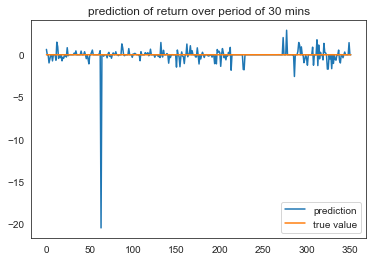

In [8]:
preds, accuracy = do_everything(n = 30, roll_window_len=1600)

In [9]:
accuracy

0.48011363636363635

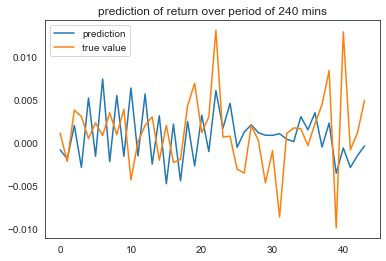

In [37]:
T = np.arange(len(preds))
true_val = df1['Logreturn2'][-len(T):]
plt.plot(T, preds, label = 'prediction')
plt.plot(T, true_val, label = 'true value')
plt.title('prediction of return over period of 240 mins')
plt.legend()

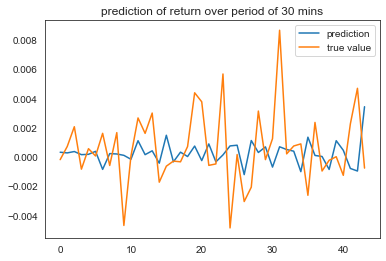

In [12]:
T = np.arange(len(preds))
df1 = plot_corrs(n = 30)
true_val = df1['Logreturn2'][-len(T):]
plt.plot(T, preds, label = 'prediction')
plt.plot(T, true_val, label = 'true value')
plt.title('prediction of return over period of 30 mins')
plt.legend()

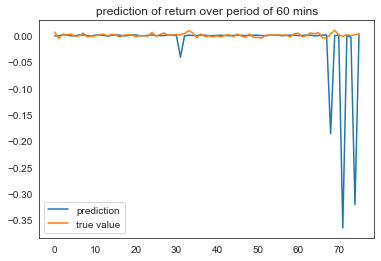

In [51]:
T = np.arange(len(preds))
true_val = df1['Logreturn2'][-len(T):]
plt.plot(T, preds, label = 'prediction')
plt.plot(T, true_val, label = 'true value')
plt.title('prediction of return over period of 60 mins')
plt.legend()

In [55]:
pred_bool = [int(preds[i] > 0) for i in range(len(preds))]
true_bool = [int(list(true_val)[i] > 0) for i in range(len(preds))]

In [58]:
sum(abs(np.asarray(true_bool) - np.asarray(pred_bool)))/len(preds)

0.5

In [19]:
preds = fit_arma_garch(df1['Logreturn2'], roll_window_len = 400, order = (1,1))

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -2744.22 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2639423550983892e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 58088492888163.305
Iteration:      3,   Func. Count:     33,   Neg. LLF: 47591782.92083314
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1395.5127443173706
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1395.5127453280595
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -2743.99 | order: (0, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 132258059.44247629
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1392.1442819140543
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1392.144282854357
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divid

aic: -2746.44 | order: (3, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 109795190.33454616
Iteration:      2,   Func. Count:     18,   Neg. LLF: 154365513148098.88
Iteration:      3,   Func. Count:     33,   Neg. LLF: 11756591.85023043
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1786373983822.6448
Iteration:      5,   Func. Count:     59,   Neg. LLF: -1397.3910902466096
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1397.3910913783052
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2740.14 | order: (0, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 331728423.49242806
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6290330857461.412
Iteration:      3,   Func. Count:     33,   Neg. LLF: 4961366.420169609
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1389.391154146727
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1389.3911547535556
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2739.34 | order: (0, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5759875354442076e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 19179259945762.562
Iteration:      3,   Func. Count:     33,   Neg. LLF: 15149666.563915903
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1389.2971154192408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1389.2971161632245
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2755.97 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9624521135.551815
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3978239118.8448977
Iteration:      3,   Func. Count:     32,   Neg. LLF: 469368.3460240702
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1403.0770569459066
            Iterations: 4
            Function evaluations: 39
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2756.18 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9767649814.36979
Iteration:      2,   Func. Count:     18,   Neg. LLF: 178290680.55445465
Iteration:      3,   Func. Count:     32,   Neg. LLF: 51485318915.035965
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1403.244014873162
            Iterations: 3
            Function evaluations: 42
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2753.89 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7665396291.711599
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1402.6925543741932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1402.6925535370106
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2753.52 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6861782239.641965
Iteration:      2,   Func. Count:     18,   Neg. LLF: 190860924280.75824
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1402.3396820620865
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1402.3396813262534
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2754.67 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10960305716.025852
Iteration:      2,   Func. Count:     18,   Neg. LLF: 998689.4675185074
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1401.992637485636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1401.9926370717985
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2754.58 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10879113197.030167
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1864109123649.9077
Iteration:      3,   Func. Count:     33,   Neg. LLF: 7116697.566270196
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1401.9545598916752
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1401.9545596161208
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2756.83 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13129863059.293112
Iteration:      2,   Func. Count:     18,   Neg. LLF: 441811.09321821376
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1404.658981637167
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2758.90 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9416705339.293453
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5133182745.855126
Iteration:      3,   Func. Count:     32,   Neg. LLF: 160963670819630.97
Iteration:      4,   Func. Count:     46,   Neg. LLF: -1407.9042110002763
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.9042099636677
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.651e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -2760.70 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11276259774.066017
Iteration:      2,   Func. Count:     18,   Neg. LLF: 531783749439.0191
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.2283693367826
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.45 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 18832036406.585606
Iteration:      2,   Func. Count:     18,   Neg. LLF: 799029.2688375792
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.7909365009064
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.29 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 17413225661.941765
Iteration:      2,   Func. Count:     18,   Neg. LLF: 201057097.54154477
Iteration:      3,   Func. Count:     32,   Neg. LLF: 317073831.689852
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.648007046257
            Iterations: 3
            Function evaluations: 42
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.68e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmod

aic: -2758.65 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8829922787.477144
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1075897604.967107
Iteration:      3,   Func. Count:     31,   Neg. LLF: -1405.2431249721808
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.2431240026763
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2758.19 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6560868993.476184
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1404.7529542175469
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1404.752953246652
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2758.81 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4784569852.096576
Iteration:      2,   Func. Count:     18,   Neg. LLF: 224461425.86094913
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.8074083279214
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.17 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1189032085.632834
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1408.3911782493678
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.3911772130214
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.43 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 594157018.0347292
Iteration:      2,   Func. Count:     18,   Neg. LLF: 20999.01656574701
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.3242061466376
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.42 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 363521374.33352566
Iteration:      2,   Func. Count:     18,   Neg. LLF: 55763.23662936861
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.1122915372425
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.46 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 239100494.04368165
Iteration:      2,   Func. Count:     18,   Neg. LLF: 180406.94788811184
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.0272278525335
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.74 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 50615451.52737777
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1408.055715990142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.0557154015908
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.50 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 232893453.98424062
Iteration:      2,   Func. Count:     18,   Neg. LLF: 581203381437007.8
Iteration:      3,   Func. Count:     33,   Neg. LLF: 100797523.05618143
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.8886340170236
            Iterations: 3
            Function evaluations: 42
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2758.98 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1950590325.7588139
Iteration:      2,   Func. Count:     18,   Neg. LLF: 77106044929.19505
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.903174711028
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2760.44 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3919535696.325828
Iteration:      2,   Func. Count:     18,   Neg. LLF: 77662471435.69092
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.1066577729862
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2757.75 | order: (0, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4303491510.157898
Iteration:      2,   Func. Count:     18,   Neg. LLF: 12813811909.591059
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1401.1218102284643
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2760.78 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3364203336.0460196
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1406.8340467784935
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.8340457389882
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2761.13 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3653219829.848815
Iteration:      2,   Func. Count:     18,   Neg. LLF: 21920119068.69059
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.098684369137
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.17 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2446212693.1158047
Iteration:      2,   Func. Count:     18,   Neg. LLF: 17746.85237971955
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.6251924642334
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.12 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 951511406.7589952
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1405.5852586885032
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.5852580959097
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.716e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.669e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:2

aic: -2761.03 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1318660038.8622046
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1406.9204076535698
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.9204068687475
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.67 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1517404252.2217133
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1405.6655077851556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.6655068214338
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.69e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmod

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergenc

aic: -2758.73 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 501774849.9861196
Iteration:      2,   Func. Count:     18,   Neg. LLF: 49302344385993.984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1404.95334583916
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2755.96 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 816576786.2917401
Iteration:      2,   Func. Count:     18,   Neg. LLF: 17030469325.692953
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1402.8028899462838
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2759.54 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 51250214.86152008
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1405.7796153161155
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1405.7796146051417
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\

aic: -2756.47 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 30577299969.758354
Iteration:      2,   Func. Count:     18,   Neg. LLF: 639160180651.9249
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1794212444.5983148
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1637203649065.872
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1216085.5036753758
Iteration:      6,   Func. Count:     73,   Neg. LLF: 2136007959.929535
Iteration:      7,   Func. Count:     85,   Neg. LLF: 104540112024.49524
Iteration:      8,   Func. Count:     99,   Neg. LLF: -1404.917229568395
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1404.9172289034398
            Iterations: 12
            Function evaluations: 99
            Gradient evaluations: 8


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2760.24 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2284541548.563069
Iteration:      2,   Func. Count:     18,   Neg. LLF: 183733.29211491902
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1981551679.7263527
Iteration:      4,   Func. Count:     40,   Neg. LLF: 209642.7977279105
Iteration:      5,   Func. Count:     50,   Neg. LLF: 1740482791.8844106
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1406.5318695557976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.5318690270271
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2760.32 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4777900795.803383
Iteration:      2,   Func. Count:     18,   Neg. LLF: 56811.79405039227
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1691938.151731321
Iteration:      4,   Func. Count:     40,   Neg. LLF: -1406.8868877541413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.8868873981341
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\ts

aic: -2760.41 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8269036.032253502
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1412069299434.382
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1896817044.8809361
Iteration:      4,   Func. Count:     45,   Neg. LLF: 206644.39518858754
Iteration:      5,   Func. Count:     55,   Neg. LLF: 404913990973.4068
Iteration:      6,   Func. Count:     69,   Neg. LLF: -1407.2391897573734
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.2391895153844
            Iterations: 10
            Function evaluations: 69
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2760.74 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13594264.253205448
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1407.8538999902166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.8538999048938
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2758.49 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 65498700.61776104
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1406.1521835875828
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.152183423295
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2758.30 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 269525321591.23163
Iteration:      2,   Func. Count:     18,   Neg. LLF: 202863502982658.5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.1407442800487
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.694e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.694e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabl

aic: -2758.33 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8.576848391938253e+17
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1406.6835544009564
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.6835544625599
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2758.33 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3837279200980296e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6018966752033.156
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5818591.476530497
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1407.3290325671921
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.329032852036
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.695e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -2762.46 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 186281306.384067
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1410.6297717733387
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1410.629772354208
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.663e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:2

aic: -2762.26 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.8735188300948787e+18
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1411.3563565622062
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1411.3563571499903
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\

aic: -2761.37 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 71029764.22595923
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1449513354199.4688
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1409.6812832425069
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.681283819683
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2764.59 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0588252030876724e+18
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1413.4477123591014
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.4477132133143
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.607e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -2762.69 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 935741816.9788618
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1413.5528085426993
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.5528097855229
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.683e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.599e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

aic: -2765.71 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5.599366019794799e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 98624169165966.23
Iteration:      3,   Func. Count:     29,   Neg. LLF: 154435719316525.62
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1532853031986063.0
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1.6580655609230487e+18
Iteration:      6,   Func. Count:     71,   Neg. LLF: 30138788744730.984
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1.9985456643602336e+16
Iteration:      8,   Func. Count:    101,   Neg. LLF: 10741910.577155149
Iteration:      9,   Func. Count:    112,   Neg. LLF: -1416.5417315382233
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1416.5417327029697
            Iterations: 13
            Function evaluations: 112
            Gradient evaluations: 9


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2767.55 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.775815652335997e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 25211499427500.664
Iteration:      3,   Func. Count:     29,   Neg. LLF: 9714167733647012.0
Iteration:      4,   Func. Count:     41,   Neg. LLF: 29147604967469.27
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5.859712536114685e+16
Iteration:      6,   Func. Count:     68,   Neg. LLF: 549159878916853.0
Iteration:      7,   Func. Count:     83,   Neg. LLF: 1.7011164056520812e+16
Iteration:      8,   Func. Count:     98,   Neg. LLF: 7.031300786329265e+17
Iteration:      9,   Func. Count:    113,   Neg. LLF: 74390279182632.55
Iteration:     10,   Func. Count:    127,   Neg. LLF: 3821761414099673.5
Iteration:     11,   Func. Count:    142,   Neg. LLF: 123416531794.10704
Iteration:     12,   Func. Count:    150,   Neg. LLF: -1417.712246063993
Optimization terminated successfully    (Exit mode 0)
            Current function v

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divid

aic: -2767.54 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.277600376530297e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 90222470928282.84
Iteration:      3,   Func. Count:     33,   Neg. LLF: 7281192330754.093
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.863502026141592e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 8.786680018805023e+17
Iteration:      6,   Func. Count:     74,   Neg. LLF: 2286461466917826.5
Iteration:      7,   Func. Count:     89,   Neg. LLF: 2022360288.651703
Iteration:      8,   Func. Count:    101,   Neg. LLF: 77548016530720.28
Iteration:      9,   Func. Count:    116,   Neg. LLF: 452974960265.11285
Iteration:     10,   Func. Count:    125,   Neg. LLF: 3.820031900513614e+17
Iteration:     11,   Func. Count:    140,   Neg. LLF: 2818666030795371.0
Iteration:     12,   Func. Count:    155,   Neg. LLF: 3224690528787.417
Iteration:     13,   Func. Count:    170,   Neg. LLF: 4.580699340438619e+21
Iteration: 

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2768.20 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.3103234912745503e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 287819183653183.1
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1.5543305262997203e+17
Iteration:      4,   Func. Count:     48,   Neg. LLF: 41550387.11534351
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2035427118988.2036
Iteration:      6,   Func. Count:     74,   Neg. LLF: -1421.2356334170922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.2356356186406
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2769.43 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 803841161.6634495
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5.042942023230032e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1.0192366798129472e+17
Iteration:      4,   Func. Count:     48,   Neg. LLF: 14543009.895547347
Iteration:      5,   Func. Count:     59,   Neg. LLF: -1421.978070389788
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.9780726417284
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2769.02 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1184628683921265e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1488050411360335.0
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1.0828989823531715e+19
Iteration:      4,   Func. Count:     45,   Neg. LLF: 428006368376908.94
Iteration:      5,   Func. Count:     60,   Neg. LLF: 359949292.91534144
Iteration:      6,   Func. Count:     71,   Neg. LLF: -1418.3903695984325
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.3903717384146
            Iterations: 10
            Function evaluations: 71
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2772.77 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 843274879.3035758
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4.162768912942234e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 7.020105422930031e+17
Iteration:      4,   Func. Count:     48,   Neg. LLF: 635679117.4335536
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.1325207743478852e+19
Iteration:      6,   Func. Count:     75,   Neg. LLF: 25617381977.972385
Iteration:      7,   Func. Count:     88,   Neg. LLF: 1.0126356511177923e+18
Iteration:      8,   Func. Count:    103,   Neg. LLF: 91161450318.48637
Iteration:      9,   Func. Count:    117,   Neg. LLF: 2.2728234937178206e+19
Iteration:     10,   Func. Count:    132,   Neg. LLF: 5.153057807950319e+21
Iteration:     11,   Func. Count:    146,   Neg. LLF: -1304.4705895515135
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1304.4705842364529
            Iterations: 15
           

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2773.42 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 509135895.5425619
Iteration:      2,   Func. Count:     18,   Neg. LLF: 672563664719528.1
Iteration:      3,   Func. Count:     33,   Neg. LLF: 647021315.3725868
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.8228750953870696e+19
Iteration:      5,   Func. Count:     60,   Neg. LLF: 42919654809.56399
Iteration:      6,   Func. Count:     74,   Neg. LLF: 3.939380238352046e+20
Iteration:      7,   Func. Count:     89,   Neg. LLF: 870966884026980.4
Iteration:      8,   Func. Count:    104,   Neg. LLF: 106949958738.31718
Iteration:      9,   Func. Count:    119,   Neg. LLF: 705436215643001.2
Iteration:     10,   Func. Count:    134,   Neg. LLF: 275948520135.13165
Iteration:     11,   Func. Count:    148,   Neg. LLF: 2.7266154616171245e+23
Iteration:     12,   Func. Count:    162,   Neg. LLF: -845.6303995960878
Optimization terminated successfully    (Exit mode 0)
            Current function value:

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2773.44 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 583292088.7933819
Iteration:      2,   Func. Count:     18,   Neg. LLF: 236602212719512.5
Iteration:      3,   Func. Count:     33,   Neg. LLF: 230512500.828447
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1427.1494466293884
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1427.1494497997364
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2773.60 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 808222982.4875304
Iteration:      2,   Func. Count:     18,   Neg. LLF: 107957929981178.23
Iteration:      3,   Func. Count:     29,   Neg. LLF: 823490477331476.8
Iteration:      4,   Func. Count:     44,   Neg. LLF: 2.2839532655511452e+16
Iteration:      5,   Func. Count:     59,   Neg. LLF: 5765959357.623019
Iteration:      6,   Func. Count:     71,   Neg. LLF: -1428.2907313053631
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.2907347552891
            Iterations: 10
            Function evaluations: 71
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2773.48 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.338829247468567e+19
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1425.7982698747603
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.7982730616409
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2775.49 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 999918969.3430326
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1.6353538951203607e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2384904879.5461445
Iteration:      4,   Func. Count:     45,   Neg. LLF: 6.502624245652424e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.3126804310221888e+18
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1076761948.4409432
Iteration:      7,   Func. Count:     86,   Neg. LLF: -1430.4379594473103
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.4379632601422
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2774.94 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 908906083.3927727
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1.3450503063160166e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: 8.900965463567898e+17
Iteration:      4,   Func. Count:     48,   Neg. LLF: 538070960.3527501
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5.901432730595901e+18
Iteration:      6,   Func. Count:     75,   Neg. LLF: 8703848049.232122
Iteration:      7,   Func. Count:     87,   Neg. LLF: -1430.5976501070295
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.597654133031
            Iterations: 11
            Function evaluations: 87
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2774.97 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1181819848.1418746
Iteration:      2,   Func. Count:     18,   Neg. LLF: 15712533.568322426
Iteration:      3,   Func. Count:     30,   Neg. LLF: 3.4238580031108284e+19
Iteration:      4,   Func. Count:     45,   Neg. LLF: 48425325121.24356
Iteration:      5,   Func. Count:     59,   Neg. LLF: 6.79642607647723e+19
Iteration:      6,   Func. Count:     74,   Neg. LLF: 5.109093295953396e+17
Iteration:      7,   Func. Count:     89,   Neg. LLF: 26785735834.03178
Iteration:      8,   Func. Count:     99,   Neg. LLF: 1183407743315.919
Iteration:      9,   Func. Count:    113,   Neg. LLF: 1.3081309771349482e+17
Iteration:     10,   Func. Count:    128,   Neg. LLF: 1345835525446742.0
Iteration:     11,   Func. Count:    142,   Neg. LLF: 113626311631.47446
Iteration:     12,   Func. Count:    155,   Neg. LLF: 2.703743625299247e+25
Iteration:     13,   Func. Count:    169,   Neg. LLF: -354.6218310554147
Optimiza

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -2774.95 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3269137152476215e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 26951593.117331393
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1.7905792608970143e+18
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.2273456870354592e+17
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.6054476712135355e+21
Iteration:      6,   Func. Count:     75,   Neg. LLF: 3.626329359233808e+21
Iteration:      7,   Func. Count:     90,   Neg. LLF: 6135111056439.611
Iteration:      8,   Func. Count:    105,   Neg. LLF: 15967227699.612568
Iteration:      9,   Func. Count:    119,   Neg. LLF: 4.372824443943164e+21
Iteration:     10,   Func. Count:    134,   Neg. LLF: 9.761612537007133e+23
Iteration:     11,   Func. Count:    148,   Neg. LLF: -728.4371125363424
Optimization terminated successfully    (Exit mode 0)
            Current function value: -728.43709558114
            Iterations: 15
         

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2786.52 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 136477837.20421255
Iteration:      2,   Func. Count:     18,   Neg. LLF: 40176818513904.67
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4.800361916390964e+16
Iteration:      4,   Func. Count:     40,   Neg. LLF: -1431.2722663018951
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1431.2722700221293
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2792.18 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 674559926.0282874
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4.748004217849179e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: 43727377454.27234
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.1029689807666486e+20
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.2859390754727204e+21
Iteration:      6,   Func. Count:     77,   Neg. LLF: 6.838434373853852e+16
Iteration:      7,   Func. Count:     92,   Neg. LLF: 4.986739273102843e+20
Iteration:      8,   Func. Count:    106,   Neg. LLF: 3.1138375739918716e+16
Iteration:      9,   Func. Count:    121,   Neg. LLF: 21943984739.116863
Iteration:     10,   Func. Count:    134,   Neg. LLF: 1.9556322361568594e+18
Iteration:     11,   Func. Count:    148,   Neg. LLF: -1429.6730051904049
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.6730078185958
            Iterations: 15
      

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.265e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -2814.20 | order: (2, 1)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4051469019.4536366
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4069217.911281633
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1431.6024639112504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1431.6024643169162
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.057e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -2823.28 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1974940483.264491
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3.956496447950203e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3552339199806854.0
Iteration:      4,   Func. Count:     47,   Neg. LLF: -1436.79595823307
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1436.795958334501
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.877e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

aic: -2824.43 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1232898222.7047725
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1.6749882383697802e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2358176586.9723244
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1.5148784455916438e+16
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2042575744.5894856
Iteration:      6,   Func. Count:     72,   Neg. LLF: 1.115727283345183e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 1523109234.0223715
Iteration:      8,   Func. Count:     99,   Neg. LLF: 2.5651932498592464e+16
Iteration:      9,   Func. Count:    114,   Neg. LLF: 2.2593499328766607e+19
Iteration:     10,   Func. Count:    126,   Neg. LLF: 1237517315353120.2
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1437.6893512922552
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1437.6893514666765
            Iterations: 15
          

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.866e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -2824.45 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 924474046.2733804
Iteration:      2,   Func. Count:     18,   Neg. LLF: 8.802247773961426e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 11793626238.710606
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1438.463912283841
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.4639127334062
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.868e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

aic: -2821.58 | order: (4, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1589852149.014507
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4.3712044555419304e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5565915159.844016
Iteration:      4,   Func. Count:     45,   Neg. LLF: 828655790.6052254
Iteration:      5,   Func. Count:     57,   Neg. LLF: 8.973168850770477e+18
Iteration:      6,   Func. Count:     72,   Neg. LLF: 74962148762959.1
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1729385181.4649286
Iteration:      8,   Func. Count:     98,   Neg. LLF: 8.227392752872555e+16
Iteration:      9,   Func. Count:    113,   Neg. LLF: 12283400232.982891
Iteration:     10,   Func. Count:    125,   Neg. LLF: -1439.3389329676697
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.3389341571435
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.875e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
esti

aic: -2821.43 | order: (3, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2038611624039494e+19
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1440.1957053653696
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1440.1957068059749
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2821.14 | order: (1, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1797266964.6715727
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4633835129696460.0
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1437.1282805212686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1437.1282815083594
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp

aic: -2826.77 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 242141993.7433783
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1441.6058587499065
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1441.6058598200652
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2828.13 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1872109572.789236
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3237121.039533595
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1313411227319918.2
Iteration:      4,   Func. Count:     46,   Neg. LLF: 9.136734294069398e+18
Iteration:      5,   Func. Count:     58,   Neg. LLF: 2859454.8570591165
Iteration:      6,   Func. Count:     70,   Neg. LLF: -1440.681000339146
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1440.6810004823515
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 6


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2839.68 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4575406600.677443
Iteration:      2,   Func. Count:     18,   Neg. LLF: 156109279.68873328
Iteration:      3,   Func. Count:     29,   Neg. LLF: -1447.6181917331905
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.6181918325674
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2849.14 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2754411131.3170567
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2424348529069595.0
Iteration:      3,   Func. Count:     33,   Neg. LLF: 874516212923.5515
Iteration:      4,   Func. Count:     45,   Neg. LLF: 485363041462920.1
Iteration:      5,   Func. Count:     60,   Neg. LLF: 519993955.7009334
Iteration:      6,   Func. Count:     72,   Neg. LLF: 2799344300004597.0
Iteration:      7,   Func. Count:     87,   Neg. LLF: 629825989256546.6
Iteration:      8,   Func. Count:    102,   Neg. LLF: 1.3389092206203854e+16
Iteration:      9,   Func. Count:    117,   Neg. LLF: 8962465617105.932
Iteration:     10,   Func. Count:    129,   Neg. LLF: 76883892029136.52
Iteration:     11,   Func. Count:    144,   Neg. LLF: 86454531361.05183
Iteration:     12,   Func. Count:    156,   Neg. LLF: 225007224012997.62
Iteration:     13,   Func. Count:    170,   Neg. LLF: -1451.6175907532831
Optimization terminated

C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.554e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -2851.19 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2456742784.3823843
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2896864108831149.0
Iteration:      3,   Func. Count:     33,   Neg. LLF: 300676294.47230923
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2873612.868852242
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1104730726388762.0
Iteration:      6,   Func. Count:     73,   Neg. LLF: 620271137662.7395
Iteration:      7,   Func. Count:     85,   Neg. LLF: 1574304.7192117432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.7889052015857
            Iterations: 11
            Function evaluations: 93
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.54e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmod

aic: -2849.84 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3845998450.131118
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2.172818993074525e+16
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2899094399.624359
Iteration:      4,   Func. Count:     45,   Neg. LLF: 3377678910386497.5
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1212760326392.5374
Iteration:      6,   Func. Count:     72,   Neg. LLF: 15371436260998.766
Iteration:      7,   Func. Count:     87,   Neg. LLF: 5346707.8589967545
Iteration:      8,   Func. Count:     99,   Neg. LLF: 4.414684206934074e+16
Iteration:      9,   Func. Count:    114,   Neg. LLF: 116500120.72767413
Iteration:     10,   Func. Count:    125,   Neg. LLF: -1452.7669099714076
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.7669095774036
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2851.45 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2978350648.8491745
Iteration:      2,   Func. Count:     18,   Neg. LLF: 790256174264001.6
Iteration:      3,   Func. Count:     33,   Neg. LLF: 120100977686.89044
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1451.7036701956972
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1451.703669765288
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.535e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.546e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:2

aic: -2849.53 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4576000409.7616
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1.6937320155874273e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: 11634522387404.057
Iteration:      4,   Func. Count:     45,   Neg. LLF: 6216757660204779.0
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6564240218.509656
Iteration:      6,   Func. Count:     72,   Neg. LLF: 873494909.8223364
Iteration:      7,   Func. Count:     84,   Neg. LLF: 1.800300983981456e+25
Iteration:      8,   Func. Count:     99,   Neg. LLF: 2914970782.2871675
Iteration:      9,   Func. Count:    111,   Neg. LLF: 3.0142532869385454e+25
Iteration:     10,   Func. Count:    125,   Neg. LLF: -1453.1826113846028
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.1826113523448
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2848.24 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13570477230093.262
Iteration:      2,   Func. Count:     18,   Neg. LLF: 788368725852659.6
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1871878714800.1343
Iteration:      4,   Func. Count:     45,   Neg. LLF: 23178695329.111416
Iteration:      5,   Func. Count:     56,   Neg. LLF: -1452.5440178103063
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.5440176218826
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2848.51 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2667107204.954886
Iteration:      2,   Func. Count:     18,   Neg. LLF: 532430365129101.75
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1253979452551.222
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1558857112490483.8
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1676368910.5425184
Iteration:      6,   Func. Count:     72,   Neg. LLF: 5548022897790270.0
Iteration:      7,   Func. Count:     87,   Neg. LLF: 682351521.2923101
Iteration:      8,   Func. Count:     99,   Neg. LLF: 4.527641703180581e+17
Iteration:      9,   Func. Count:    114,   Neg. LLF: 972616904.4185514
Iteration:     10,   Func. Count:    126,   Neg. LLF: 2.515693581560166e+16
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1450.1708575598939
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.1708570719939
            Iterations: 15
            Function evalua

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2846.07 | order: (3, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2606523135.6492705
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1.2425030441382753e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2734278435.9049115
Iteration:      4,   Func. Count:     45,   Neg. LLF: 83154101344.60599
Iteration:      5,   Func. Count:     56,   Neg. LLF: -1450.2365236229025
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.2365230850303
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 5


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupporte

aic: -2849.22 | order: (4, 4)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2521145314.967323
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1.4494496684937546e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: 204690280.088356
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.6137742868873508e+16
Iteration:      5,   Func. Count:     60,   Neg. LLF: 4017210679.515823
Iteration:      6,   Func. Count:     72,   Neg. LLF: 39612874.92176266
Iteration:      7,   Func. Count:     83,   Neg. LLF: -1450.6247544879175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.624754266491
            Iterations: 11
            Function evaluations: 83
            Gradient evaluations: 7


C:\Users\john\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.543e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ i

In [16]:
d = 0
T = 401
best_aic, best_order, best_mdl = get_best_model(df1['Logreturn2'][d:d+T])
#arima_model_fitted = pmdarima.auto_arima(df[d:d+T])
#p, d, q = arima_model_fitted.order
arima_residuals = best_mdl.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = best_mdl.forecast()[0]
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# # Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\john\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

aic: -2752.08 | order: (2, 3)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 191730083.93269122
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1399.7505602427061
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1399.7505613169383
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


C:\Users\john\Anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.939e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\john\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [13]:
best_mdl.forecast()[0]

-0.0002891261728307278

In [12]:
df1['Logreturn2'][d:d+T+1]

ind
0       -0.012969
120     -0.000944
240      0.003099
360     -0.000943
480      0.028900
           ...   
47520    0.000153
47640   -0.002812
47760   -0.005809
47880   -0.000567
48000   -0.001903
Name: Logreturn2, Length: 401, dtype: float64

In [20]:
preds

[0.00014586003636643335,
 0.0005504022866104206,
 0.0008917629286607626,
 -0.00019040997149152113,
 0.0002495843605518503,
 -0.00025662535281766985,
 0.0002845038882389755,
 0.0011080765000294687,
 0.0009187086141718802,
 -0.0005511726310527873,
 0.00010740993995765949,
 0.0020521583649157314,
 -0.0002251817054323503,
 0.0006526300210504979,
 -0.00017696999471421965,
 0.0015164502628520304,
 0.0005577765431992881,
 5.729993026839229e-05,
 -0.000922445901306735,
 0.001014603681630694,
 0.0006259176701425038,
 -0.00019576844258782243,
 0.00034802252782688953,
 0.001126051469061441,
 0.00047917605741423937,
 -0.0008255271335931126,
 0.0011068974846725507,
 3.07454856467324e-05,
 -0.0018399210082359345,
 0.0015650881607367482,
 0.0008355824764776597,
 0.00030259814523019046,
 -0.0016712733056499104,
 0.0021906509952805565,
 -0.001023222595385096,
 0.0006822997759193191,
 -3.287220181378813e-05,
 0.0010765425902974617,
 -0.0014035824171031513,
 0.0006393130149915753,
 -5.9587221171814096e-0

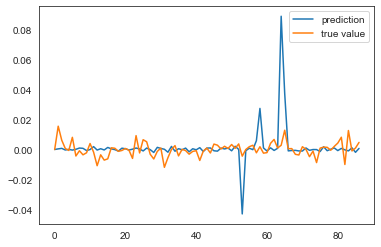

In [22]:
T = np.arange(len(preds))
true_val = df1['Logreturn2'][-len(T):]
plt.plot(T, preds, label = 'prediction')
plt.plot(T, true_val, label = 'true value')
plt.legend()

In [23]:
len(T)

87